# N:2 MENT — sample-based solver

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj2D_Contour
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Source distribution

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

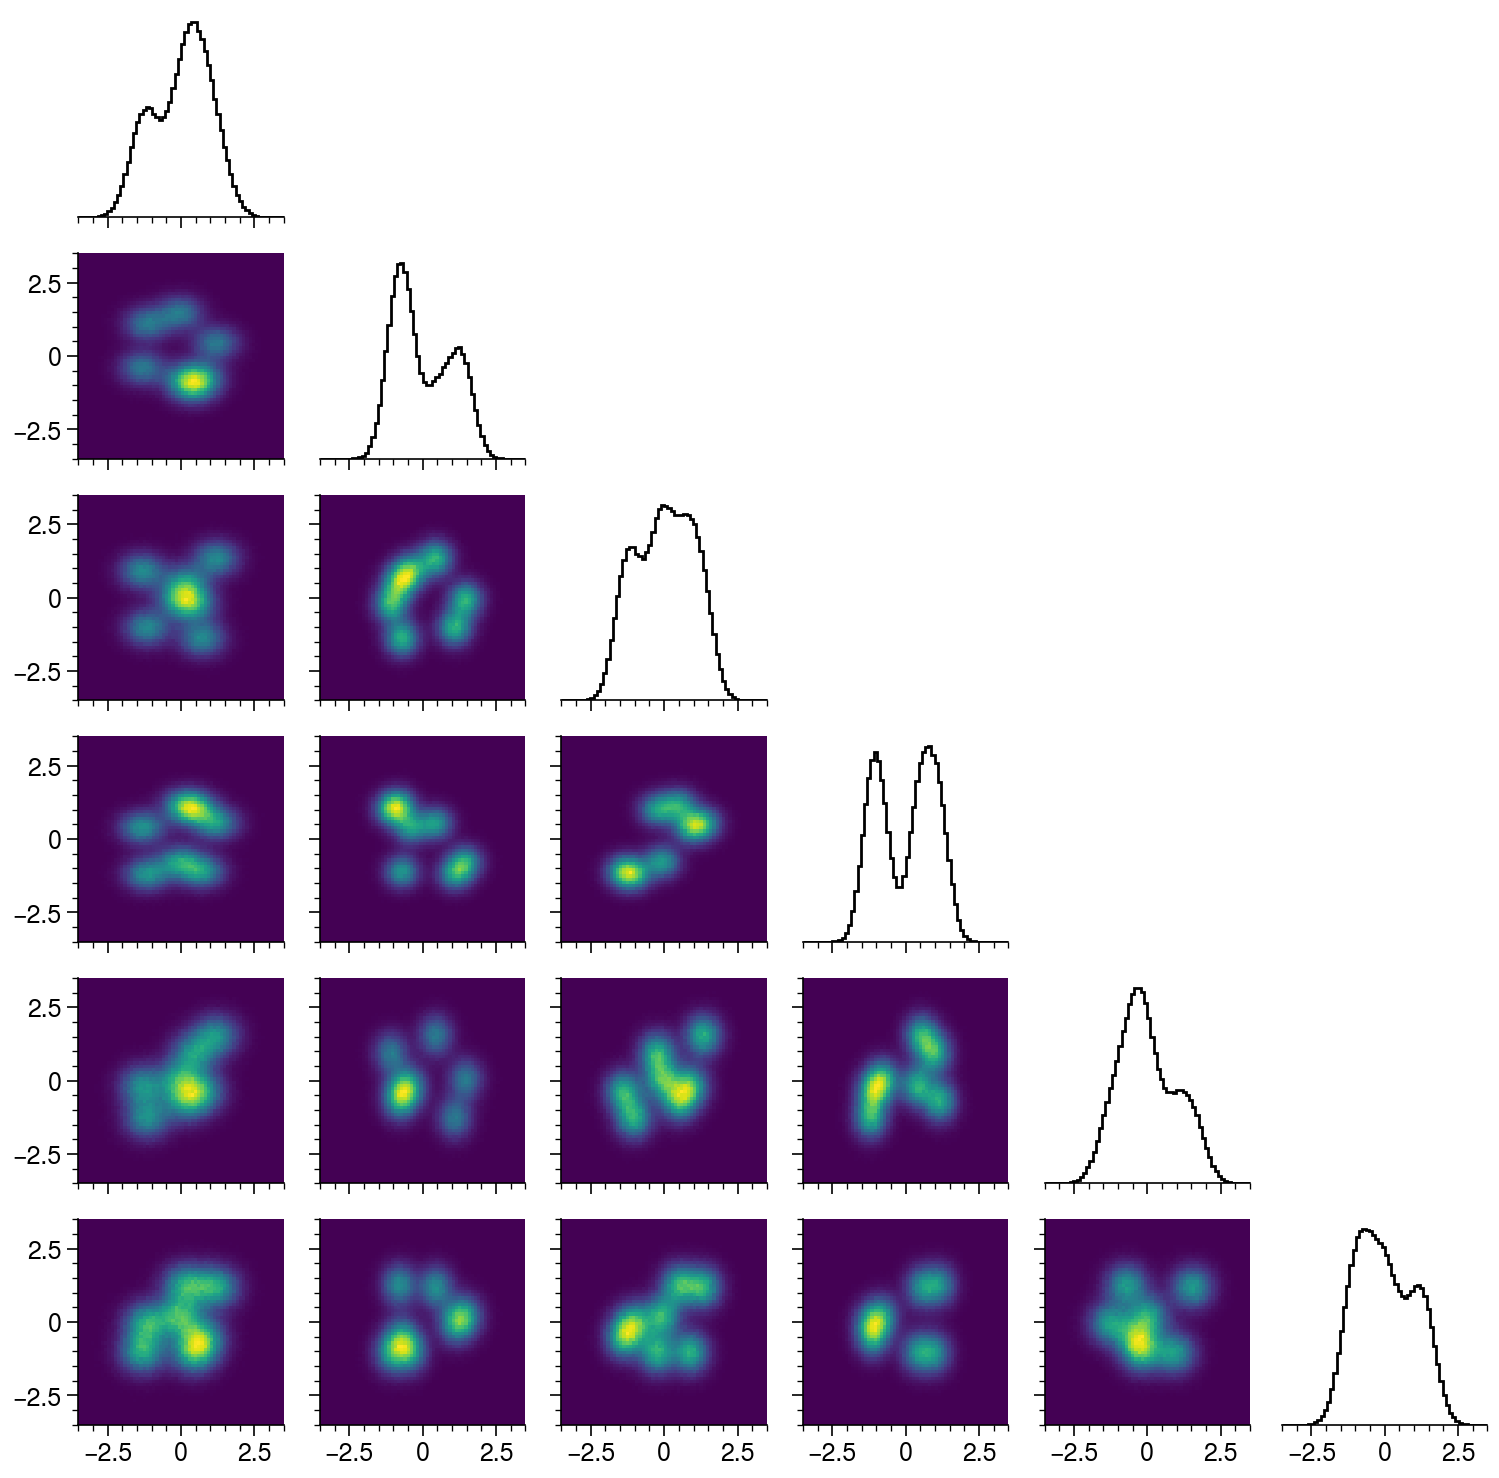

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = ndim * (ndim - 1) // 2
nbins = 64
blur = 0.0
kde = False
kde_bandwidth_frac = 1.0
axis_meas = (0, 2)

In [7]:
# Create transforms (permutation matrices)
transfer_matrices = []
for i in range(ndim):
    for j in range(i):
        matrices = []
        for k, l in zip(axis_meas, (j, i)):
            matrix = np.identity(ndim)
            matrix[k, k] = matrix[l, l] = 0.0
            matrix[k, l] = matrix[l, k] = 1.0
            matrices.append(matrix)
        transfer_matrices.append(np.linalg.multi_dot(matrices[::-1]))

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas
bin_edges = 2 * [np.linspace(-xmax, xmax, nbins + 1)]

projections = []
for transform in transforms:
    projection = ment.diag.HistogramND(
        axis=axis_meas,
        edges=bin_edges,
        kde=kde,
        kde_bandwidth_frac=kde_bandwidth_frac,
        blur=blur,
        thresh=0.0,
        thresh_type="abs",
    )
    projections.append([projection])

# Generate data
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=False,
    thresh=5.00e-03,
)

In [8]:
# @interact(index=(0, nmeas - 1))
# def update(index: int):
#     coords = unravel(projections)[index].coords
#     values = unravel(projections)[index].values

#     fig, ax = plt.subplots()
#     ax.pcolormesh(coords[0], coords[1], values.T, colorbar=True,)

## Model

In [9]:
sampler = "mcmc"
nsamp = 1_000_000
burnin = 500
chains = 1000
c = 2.4 / np.sqrt(ndim)

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    proposal_cov = 0.1 * np.eye(ndim)

    start = np.random.multivariate_normal(np.zeros(ndim), 0.5 * np.eye(ndim), size=chains)

    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=chains,
        proposal_cov=proposal_cov,
        start=start,
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [10]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=0,
)

## Training

In [11]:
plot_nsamp = 1_000_000

In [12]:
def plot_model(model):
    figs = []

    # Sample particles
    x_pred = model.sample(plot_nsamp)

    # Plot reconstructed vs. true distribution
    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot_points(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Simulate measurements
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate_with_diag_update(
        x_pred, transforms, projections_pred, kde=False, blur=False
    )

    projections_true = unravel(projections_true)
    projections_pred = unravel(projections_pred)

    # Plot simulated vs. measured projections.
    contour_levels = np.linspace(0.01, 1.0, 7)
    contour_colors = ["black", "red"]
    plot_kws = dict(
        process_kws=dict(blur=1.0, scale="max"),
        kind="contour",
        levels=contour_levels,
        lw=0.9,
    )

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figwidth=(1.1 * ncols))
    for proj_true, proj_pred, ax in zip(projections_true, projections_pred, axs):
        psv.plot_hist(proj_true, ax=ax, colors=contour_colors[0], **plot_kws)
        psv.plot_hist(proj_pred, ax=ax, colors=contour_colors[1], **plot_kws)
    figs.append(fig)

    return figs

non numeric history values being saved


  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 702.41it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 687.50it/s]

 14%|███████████████▊                                                                                                | 212/1499 [00:00<00:01, 691.46it/s]

 19%|█████████████████████▏                                                                                          | 283/1499 [00:00<00:01, 696.68it/s]

 24%|██████████████████████████▎                                                                                     | 353/1499 [00:00<00:01, 697.64it/s]

 28%|███████████████████████████████▉                                                                                | 427/1499 [00:00<00:01, 708.39it/s]

 33%|█████████████████████████████████████▏                                                                          | 498/1499 [00:00<00:01, 698.41it/s]

 38%|██████████████████████████████████████████▍                                                                     | 568/1499 [00:00<00:01, 698.45it/s]

 43%|███████████████████████████████████████████████▋                                                                | 638/1499 [00:00<00:01, 692.84it/s]

 47%|█████████████████████████████████████████████████████                                                           | 710/1499 [00:01<00:01, 700.62it/s]

 52%|██████████████████████████████████████████████████████████▎                                                     | 781/1499 [00:01<00:01, 701.45it/s]

 57%|███████████████████████████████████████████████████████████████▋                                                | 852/1499 [00:01<00:00, 700.37it/s]

 62%|█████████████████████████████████████████████████████████████████████                                           | 925/1499 [00:01<00:00, 706.60it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                     | 998/1499 [00:01<00:00, 710.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1071/1499 [00:01<00:00, 716.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1143/1499 [00:01<00:00, 711.94it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1215/1499 [00:01<00:00, 706.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1289/1499 [00:01<00:00, 713.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1362/1499 [00:01<00:00, 715.53it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1434/1499 [00:02<00:00, 712.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 705.25it/s]

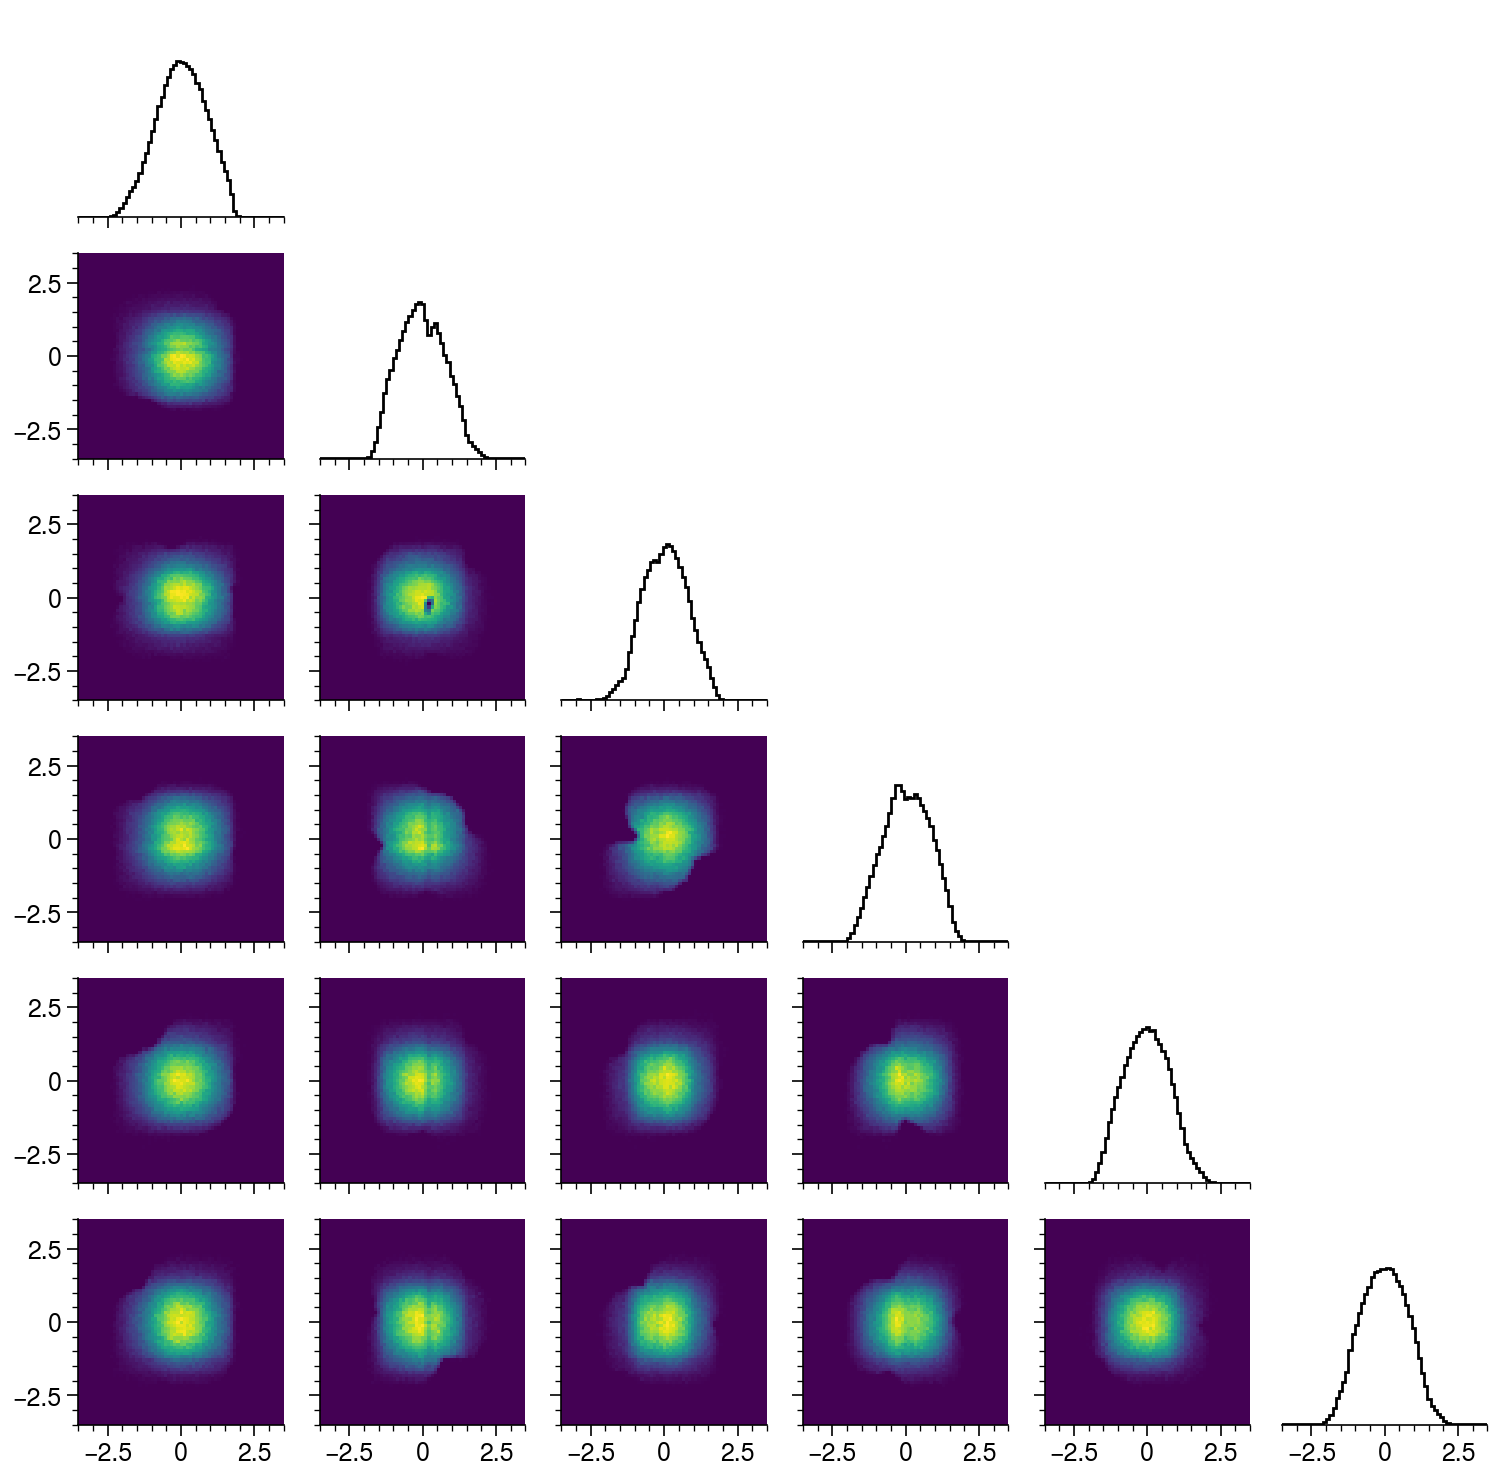

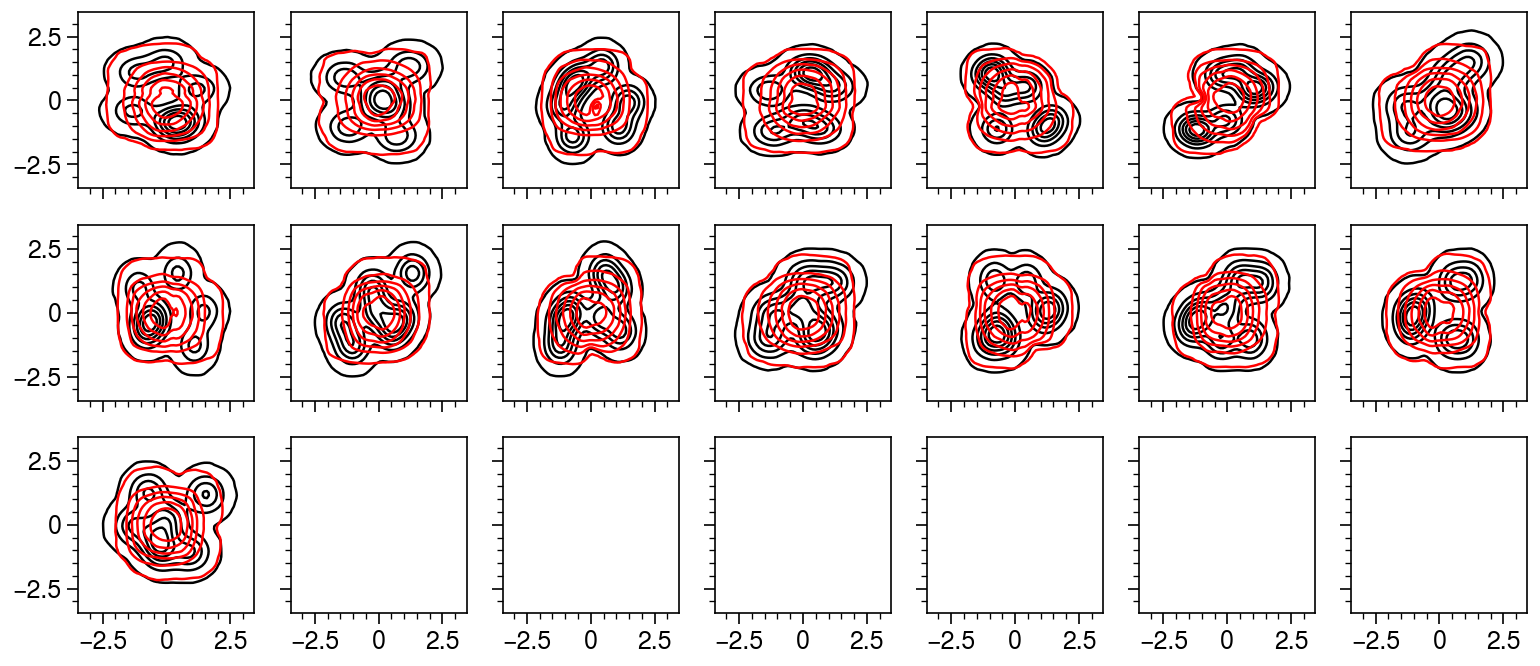

None
epoch = 1


  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 686.92it/s]

  9%|██████████▌                                                                                                     | 141/1499 [00:00<00:01, 703.80it/s]

 14%|███████████████▉                                                                                                | 214/1499 [00:00<00:01, 713.85it/s]

 19%|█████████████████████▌                                                                                          | 288/1499 [00:00<00:01, 720.27it/s]

 24%|██████████████████████████▉                                                                                     | 361/1499 [00:00<00:01, 722.32it/s]

 29%|████████████████████████████████▍                                                                               | 434/1499 [00:00<00:01, 715.84it/s]

 34%|█████████████████████████████████████▊                                                                          | 506/1499 [00:00<00:01, 714.62it/s]

 39%|███████████████████████████████████████████▎                                                                    | 580/1499 [00:00<00:01, 720.33it/s]

 44%|████████████████████████████████████████████████▊                                                               | 653/1499 [00:00<00:01, 717.69it/s]

 48%|██████████████████████████████████████████████████████▏                                                         | 726/1499 [00:01<00:01, 721.31it/s]

 53%|███████████████████████████████████████████████████████████▊                                                    | 800/1499 [00:01<00:00, 725.06it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                              | 874/1499 [00:01<00:00, 727.49it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                         | 948/1499 [00:01<00:00, 729.01it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1021/1499 [00:01<00:00, 723.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1094/1499 [00:01<00:00, 715.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1166/1499 [00:01<00:00, 712.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1238/1499 [00:01<00:00, 711.18it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1310/1499 [00:01<00:00, 713.32it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1383/1499 [00:01<00:00, 717.99it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1456/1499 [00:02<00:00, 721.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 718.79it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▍                                                                                                           | 72/1499 [00:00<00:02, 712.86it/s]

 10%|██████████▊                                                                                                     | 144/1499 [00:00<00:01, 701.02it/s]

 14%|████████████████                                                                                                | 215/1499 [00:00<00:01, 700.52it/s]

 19%|█████████████████████▌                                                                                          | 288/1499 [00:00<00:01, 708.45it/s]

 24%|██████████████████████████▊                                                                                     | 359/1499 [00:00<00:01, 704.06it/s]

 29%|████████████████████████████████▏                                                                               | 430/1499 [00:00<00:01, 699.29it/s]

 33%|█████████████████████████████████████▎                                                                          | 500/1499 [00:00<00:01, 694.84it/s]

 38%|██████████████████████████████████████████▋                                                                     | 571/1499 [00:00<00:01, 697.02it/s]

 43%|████████████████████████████████████████████████                                                                | 644/1499 [00:00<00:01, 706.45it/s]

 48%|█████████████████████████████████████████████████████▍                                                          | 715/1499 [00:01<00:01, 703.25it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 788/1499 [00:01<00:01, 710.31it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 860/1499 [00:01<00:00, 707.49it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                          | 931/1499 [00:01<00:00, 706.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1004/1499 [00:01<00:00, 711.72it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1076/1499 [00:01<00:00, 707.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1148/1499 [00:01<00:00, 711.33it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1221/1499 [00:01<00:00, 715.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1295/1499 [00:01<00:00, 720.69it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1368/1499 [00:01<00:00, 716.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1441/1499 [00:02<00:00, 720.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 709.52it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  4%|█████                                                                                                            | 67/1499 [00:00<00:02, 660.14it/s]

  9%|██████████                                                                                                      | 134/1499 [00:00<00:02, 656.58it/s]

 13%|██████████████▉                                                                                                 | 200/1499 [00:00<00:01, 654.82it/s]

 18%|████████████████████▏                                                                                           | 270/1499 [00:00<00:01, 671.58it/s]

 23%|█████████████████████████▎                                                                                      | 338/1499 [00:00<00:01, 654.93it/s]

 27%|██████████████████████████████▏                                                                                 | 404/1499 [00:00<00:01, 655.06it/s]

 31%|███████████████████████████████████▏                                                                            | 471/1499 [00:00<00:01, 656.45it/s]

 36%|████████████████████████████████████████▍                                                                       | 542/1499 [00:00<00:01, 671.88it/s]

 41%|█████████████████████████████████████████████▉                                                                  | 614/1499 [00:00<00:01, 683.94it/s]

 46%|███████████████████████████████████████████████████                                                             | 684/1499 [00:01<00:01, 687.63it/s]

 51%|████████████████████████████████████████████████████████▌                                                       | 757/1499 [00:01<00:01, 698.28it/s]

 55%|██████████████████████████████████████████████████████████████                                                  | 830/1499 [00:01<00:00, 706.06it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                            | 902/1499 [00:01<00:00, 709.70it/s]

 65%|████████████████████████████████████████████████████████████████████████▊                                       | 974/1499 [00:01<00:00, 711.97it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1046/1499 [00:01<00:00, 712.45it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1118/1499 [00:01<00:00, 710.70it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1190/1499 [00:01<00:00, 706.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1261/1499 [00:01<00:00, 703.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1332/1499 [00:01<00:00, 701.00it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1403/1499 [00:02<00:00, 699.34it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1473/1499 [00:02<00:00, 698.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 690.15it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 684.50it/s]

  9%|██████████▎                                                                                                     | 138/1499 [00:00<00:01, 684.20it/s]

 14%|███████████████▍                                                                                                | 207/1499 [00:00<00:01, 682.26it/s]

 19%|████████████████████▊                                                                                           | 279/1499 [00:00<00:01, 695.08it/s]

 23%|██████████████████████████                                                                                      | 349/1499 [00:00<00:01, 696.62it/s]

 28%|███████████████████████████████▍                                                                                | 421/1499 [00:00<00:01, 703.15it/s]

 33%|████████████████████████████████████▊                                                                           | 492/1499 [00:00<00:01, 700.61it/s]

 38%|██████████████████████████████████████████                                                                      | 563/1499 [00:00<00:01, 702.14it/s]

 42%|███████████████████████████████████████████████▍                                                                | 635/1499 [00:00<00:01, 706.48it/s]

 47%|████████████████████████████████████████████████████▉                                                           | 708/1499 [00:01<00:01, 711.24it/s]

 52%|██████████████████████████████████████████████████████████▎                                                     | 781/1499 [00:01<00:01, 716.29it/s]

 57%|███████████████████████████████████████████████████████████████▋                                                | 853/1499 [00:01<00:00, 711.09it/s]

 62%|█████████████████████████████████████████████████████████████████████                                           | 925/1499 [00:01<00:00, 712.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                     | 997/1499 [00:01<00:00, 714.06it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1069/1499 [00:01<00:00, 709.63it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1142/1499 [00:01<00:00, 712.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1215/1499 [00:01<00:00, 715.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1287/1499 [00:01<00:00, 709.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1358/1499 [00:01<00:00, 705.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1429/1499 [00:02<00:00, 699.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 705.82it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▍                                                                                                           | 72/1499 [00:00<00:02, 712.07it/s]

 10%|██████████▊                                                                                                     | 144/1499 [00:00<00:01, 716.62it/s]

 14%|████████████████▏                                                                                               | 217/1499 [00:00<00:01, 719.27it/s]

 19%|█████████████████████▌                                                                                          | 289/1499 [00:00<00:01, 709.90it/s]

 24%|██████████████████████████▉                                                                                     | 361/1499 [00:00<00:01, 706.34it/s]

 29%|████████████████████████████████▎                                                                               | 433/1499 [00:00<00:01, 709.71it/s]

 34%|█████████████████████████████████████▋                                                                          | 504/1499 [00:00<00:01, 705.45it/s]

 38%|██████████████████████████████████████████▉                                                                     | 575/1499 [00:00<00:01, 702.82it/s]

 43%|████████████████████████████████████████████████▎                                                               | 646/1499 [00:00<00:01, 699.72it/s]

 48%|█████████████████████████████████████████████████████▋                                                          | 718/1499 [00:01<00:01, 703.21it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 789/1499 [00:01<00:01, 700.89it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 861/1499 [00:01<00:00, 705.66it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                          | 933/1499 [00:01<00:00, 709.70it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1004/1499 [00:01<00:00, 705.06it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1076/1499 [00:01<00:00, 709.28it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1147/1499 [00:01<00:00, 705.58it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1219/1499 [00:01<00:00, 708.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1291/1499 [00:01<00:00, 711.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1363/1499 [00:01<00:00, 708.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1435/1499 [00:02<00:00, 711.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 708.37it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 675.10it/s]

  9%|██████████▏                                                                                                     | 136/1499 [00:00<00:02, 648.64it/s]

 13%|███████████████                                                                                                 | 202/1499 [00:00<00:01, 651.42it/s]

 18%|████████████████████                                                                                            | 268/1499 [00:00<00:01, 654.11it/s]

 22%|█████████████████████████                                                                                       | 335/1499 [00:00<00:01, 657.85it/s]

 27%|██████████████████████████████▎                                                                                 | 406/1499 [00:00<00:01, 673.56it/s]

 32%|███████████████████████████████████▋                                                                            | 478/1499 [00:00<00:01, 685.54it/s]

 36%|████████████████████████████████████████▊                                                                       | 547/1499 [00:00<00:01, 669.10it/s]

 41%|█████████████████████████████████████████████▉                                                                  | 614/1499 [00:00<00:01, 664.06it/s]

 45%|██████████████████████████████████████████████████▉                                                             | 681/1499 [00:01<00:01, 664.28it/s]

 50%|████████████████████████████████████████████████████████                                                        | 751/1499 [00:01<00:01, 673.55it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 822/1499 [00:01<00:00, 681.80it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                             | 892/1499 [00:01<00:00, 685.51it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                        | 962/1499 [00:01<00:00, 689.52it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1032/1499 [00:01<00:00, 691.25it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1102/1499 [00:01<00:00, 688.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1173/1499 [00:01<00:00, 694.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1244/1499 [00:01<00:00, 698.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1316/1499 [00:01<00:00, 704.46it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1387/1499 [00:02<00:00, 701.05it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1459/1499 [00:02<00:00, 706.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 683.89it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 688.13it/s]

  9%|██████████▌                                                                                                     | 141/1499 [00:00<00:01, 704.84it/s]

 14%|███████████████▉                                                                                                | 214/1499 [00:00<00:01, 711.40it/s]

 19%|█████████████████████▎                                                                                          | 286/1499 [00:00<00:01, 711.94it/s]

 24%|██████████████████████████▋                                                                                     | 358/1499 [00:00<00:01, 706.52it/s]

 29%|████████████████████████████████                                                                                | 429/1499 [00:00<00:01, 703.74it/s]

 33%|█████████████████████████████████████▍                                                                          | 501/1499 [00:00<00:01, 707.44it/s]

 38%|██████████████████████████████████████████▋                                                                     | 572/1499 [00:00<00:01, 702.80it/s]

 43%|████████████████████████████████████████████████                                                                | 643/1499 [00:00<00:01, 694.81it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 713/1499 [00:01<00:01, 694.83it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 785/1499 [00:01<00:01, 701.09it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 857/1499 [00:01<00:00, 706.21it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                          | 928/1499 [00:01<00:00, 701.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 999/1499 [00:01<00:00, 700.22it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1071/1499 [00:01<00:00, 705.27it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1143/1499 [00:01<00:00, 709.47it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1215/1499 [00:01<00:00, 712.44it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1287/1499 [00:01<00:00, 708.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1360/1499 [00:01<00:00, 713.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1432/1499 [00:02<00:00, 710.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 706.66it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 688.37it/s]

  9%|██████████▍                                                                                                     | 139/1499 [00:00<00:01, 691.77it/s]

 14%|███████████████▌                                                                                                | 209/1499 [00:00<00:01, 693.98it/s]

 19%|█████████████████████                                                                                           | 282/1499 [00:00<00:01, 703.46it/s]

 24%|██████████████████████████▌                                                                                     | 355/1499 [00:00<00:01, 710.20it/s]

 28%|███████████████████████████████▉                                                                                | 427/1499 [00:00<00:01, 706.20it/s]

 33%|█████████████████████████████████████▏                                                                          | 498/1499 [00:00<00:01, 702.15it/s]

 38%|██████████████████████████████████████████▌                                                                     | 569/1499 [00:00<00:01, 701.10it/s]

 43%|███████████████████████████████████████████████▊                                                                | 640/1499 [00:00<00:01, 699.10it/s]

 47%|█████████████████████████████████████████████████████▏                                                          | 712/1499 [00:01<00:01, 703.92it/s]

 52%|██████████████████████████████████████████████████████████▌                                                     | 784/1499 [00:01<00:01, 707.90it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                | 856/1499 [00:01<00:00, 710.05it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                          | 928/1499 [00:01<00:00, 712.33it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1000/1499 [00:01<00:00, 714.44it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1072/1499 [00:01<00:00, 715.65it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1144/1499 [00:01<00:00, 709.17it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1217/1499 [00:01<00:00, 714.10it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1289/1499 [00:01<00:00, 709.69it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1360/1499 [00:01<00:00, 708.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1433/1499 [00:02<00:00, 712.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 708.07it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  4%|█████                                                                                                            | 67/1499 [00:00<00:02, 669.66it/s]

  9%|██████████▎                                                                                                     | 138/1499 [00:00<00:01, 688.81it/s]

 14%|███████████████▋                                                                                                | 210/1499 [00:00<00:01, 698.12it/s]

 19%|█████████████████████                                                                                           | 282/1499 [00:00<00:01, 702.24it/s]

 24%|██████████████████████████▍                                                                                     | 354/1499 [00:00<00:01, 706.66it/s]

 28%|███████████████████████████████▊                                                                                | 426/1499 [00:00<00:01, 710.04it/s]

 33%|█████████████████████████████████████▏                                                                          | 498/1499 [00:00<00:01, 712.48it/s]

 38%|██████████████████████████████████████████▌                                                                     | 570/1499 [00:00<00:01, 706.72it/s]

 43%|███████████████████████████████████████████████▉                                                                | 641/1499 [00:00<00:01, 707.14it/s]

 47%|█████████████████████████████████████████████████████▏                                                          | 712/1499 [00:01<00:01, 703.44it/s]

 52%|██████████████████████████████████████████████████████████▌                                                     | 784/1499 [00:01<00:01, 706.17it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                | 855/1499 [00:01<00:00, 703.13it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                          | 927/1499 [00:01<00:00, 707.54it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 999/1499 [00:01<00:00, 710.54it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1071/1499 [00:01<00:00, 706.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1143/1499 [00:01<00:00, 710.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1215/1499 [00:01<00:00, 705.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1286/1499 [00:01<00:00, 702.69it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1358/1499 [00:01<00:00, 706.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1429/1499 [00:02<00:00, 703.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 705.75it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 687.00it/s]

  9%|██████████▌                                                                                                     | 141/1499 [00:00<00:01, 697.91it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 704.82it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 708.06it/s]

 24%|██████████████████████████▋                                                                                     | 357/1499 [00:00<00:01, 712.18it/s]

 29%|████████████████████████████████                                                                                | 429/1499 [00:00<00:01, 705.90it/s]

 33%|█████████████████████████████████████▎                                                                          | 500/1499 [00:00<00:01, 703.21it/s]

 38%|██████████████████████████████████████████▊                                                                     | 573/1499 [00:00<00:01, 709.11it/s]

 43%|████████████████████████████████████████████████▏                                                               | 645/1499 [00:00<00:01, 711.50it/s]

 48%|█████████████████████████████████████████████████████▌                                                          | 717/1499 [00:01<00:01, 713.49it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 789/1499 [00:01<00:00, 714.07it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 861/1499 [00:01<00:00, 713.60it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                          | 933/1499 [00:01<00:00, 712.68it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1005/1499 [00:01<00:00, 707.48it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1078/1499 [00:01<00:00, 711.94it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1151/1499 [00:01<00:00, 715.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1223/1499 [00:01<00:00, 713.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1295/1499 [00:01<00:00, 710.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1367/1499 [00:01<00:00, 713.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1439/1499 [00:02<00:00, 708.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 709.34it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 686.06it/s]

  9%|██████████▍                                                                                                     | 139/1499 [00:00<00:01, 692.66it/s]

 14%|███████████████▊                                                                                                | 211/1499 [00:00<00:01, 703.97it/s]

 19%|█████████████████████▏                                                                                          | 283/1499 [00:00<00:01, 710.22it/s]

 24%|██████████████████████████▌                                                                                     | 355/1499 [00:00<00:01, 712.67it/s]

 28%|███████████████████████████████▉                                                                                | 427/1499 [00:00<00:01, 708.92it/s]

 33%|█████████████████████████████████████▏                                                                          | 498/1499 [00:00<00:01, 692.71it/s]

 38%|██████████████████████████████████████████▌                                                                     | 570/1499 [00:00<00:01, 699.64it/s]

 43%|███████████████████████████████████████████████▉                                                                | 642/1499 [00:00<00:01, 705.02it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 713/1499 [00:01<00:01, 702.37it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 785/1499 [00:01<00:01, 707.60it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 858/1499 [00:01<00:00, 712.17it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 930/1499 [00:01<00:00, 708.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1002/1499 [00:01<00:00, 711.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1074/1499 [00:01<00:00, 712.67it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1146/1499 [00:01<00:00, 703.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1217/1499 [00:01<00:00, 701.25it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1289/1499 [00:01<00:00, 705.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1360/1499 [00:01<00:00, 702.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1433/1499 [00:02<00:00, 708.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 705.35it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 703.47it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 690.11it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 696.79it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 703.73it/s]

 24%|██████████████████████████▌                                                                                     | 356/1499 [00:00<00:01, 698.56it/s]

 28%|███████████████████████████████▊                                                                                | 426/1499 [00:00<00:01, 696.34it/s]

 33%|█████████████████████████████████████                                                                           | 496/1499 [00:00<00:01, 696.04it/s]

 38%|██████████████████████████████████████████▍                                                                     | 568/1499 [00:00<00:01, 702.72it/s]

 43%|███████████████████████████████████████████████▋                                                                | 639/1499 [00:00<00:01, 701.48it/s]

 47%|█████████████████████████████████████████████████████                                                           | 711/1499 [00:01<00:01, 705.33it/s]

 52%|██████████████████████████████████████████████████████████▍                                                     | 782/1499 [00:01<00:01, 705.03it/s]

 57%|███████████████████████████████████████████████████████████████▋                                                | 853/1499 [00:01<00:00, 704.98it/s]

 62%|█████████████████████████████████████████████████████████████████████                                           | 924/1499 [00:01<00:00, 700.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                     | 995/1499 [00:01<00:00, 700.11it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1067/1499 [00:01<00:00, 704.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1138/1499 [00:01<00:00, 694.98it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1208/1499 [00:01<00:00, 677.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1276/1499 [00:01<00:00, 660.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1343/1499 [00:01<00:00, 653.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1409/1499 [00:02<00:00, 649.39it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1475/1499 [00:02<00:00, 651.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 684.70it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 676.66it/s]

  9%|██████████▍                                                                                                     | 140/1499 [00:00<00:01, 699.34it/s]

 14%|███████████████▋                                                                                                | 210/1499 [00:00<00:01, 698.82it/s]

 19%|████████████████████▉                                                                                           | 280/1499 [00:00<00:01, 697.44it/s]

 23%|██████████████████████████▏                                                                                     | 350/1499 [00:00<00:01, 691.86it/s]

 28%|███████████████████████████████▍                                                                                | 420/1499 [00:00<00:01, 693.72it/s]

 33%|████████████████████████████████████▌                                                                           | 490/1499 [00:00<00:01, 694.79it/s]

 37%|█████████████████████████████████████████▊                                                                      | 560/1499 [00:00<00:01, 693.45it/s]

 42%|███████████████████████████████████████████████▏                                                                | 632/1499 [00:00<00:01, 701.36it/s]

 47%|████████████████████████████████████████████████████▌                                                           | 703/1499 [00:01<00:01, 696.31it/s]

 52%|█████████████████████████████████████████████████████████▉                                                      | 775/1499 [00:01<00:01, 702.03it/s]

 56%|███████████████████████████████████████████████████████████████▏                                                | 846/1499 [00:01<00:00, 698.25it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                           | 917/1499 [00:01<00:00, 701.44it/s]

 66%|█████████████████████████████████████████████████████████████████████████▉                                      | 989/1499 [00:01<00:00, 705.85it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1060/1499 [00:01<00:00, 700.71it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1132/1499 [00:01<00:00, 703.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1203/1499 [00:01<00:00, 702.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1274/1499 [00:01<00:00, 699.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1344/1499 [00:01<00:00, 698.28it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1416/1499 [00:02<00:00, 701.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1488/1499 [00:02<00:00, 705.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 699.42it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  4%|█████                                                                                                            | 67/1499 [00:00<00:02, 669.71it/s]

  9%|██████████                                                                                                      | 135/1499 [00:00<00:02, 673.78it/s]

 14%|███████████████▍                                                                                                | 207/1499 [00:00<00:01, 692.66it/s]

 19%|████████████████████▉                                                                                           | 280/1499 [00:00<00:01, 703.07it/s]

 23%|██████████████████████████▏                                                                                     | 351/1499 [00:00<00:01, 697.01it/s]

 28%|███████████████████████████████▍                                                                                | 421/1499 [00:00<00:01, 690.22it/s]

 33%|████████████████████████████████████▋                                                                           | 491/1499 [00:00<00:01, 691.10it/s]

 37%|█████████████████████████████████████████▉                                                                      | 561/1499 [00:00<00:01, 693.22it/s]

 42%|███████████████████████████████████████████████▏                                                                | 631/1499 [00:00<00:01, 695.06it/s]

 47%|████████████████████████████████████████████████████▍                                                           | 701/1499 [00:01<00:01, 694.81it/s]

 52%|█████████████████████████████████████████████████████████▋                                                      | 772/1499 [00:01<00:01, 699.24it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                 | 842/1499 [00:01<00:00, 694.49it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                           | 912/1499 [00:01<00:00, 693.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                      | 982/1499 [00:01<00:00, 691.74it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1054/1499 [00:01<00:00, 698.03it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1125/1499 [00:01<00:00, 701.43it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1196/1499 [00:01<00:00, 702.14it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1267/1499 [00:01<00:00, 703.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1338/1499 [00:01<00:00, 699.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1408/1499 [00:02<00:00, 698.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1480/1499 [00:02<00:00, 702.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 696.79it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 685.80it/s]

  9%|██████████▎                                                                                                     | 138/1499 [00:00<00:01, 684.47it/s]

 14%|███████████████▍                                                                                                | 207/1499 [00:00<00:01, 675.33it/s]

 19%|████████████████████▊                                                                                           | 278/1499 [00:00<00:01, 687.69it/s]

 23%|█████████████████████████▉                                                                                      | 347/1499 [00:00<00:01, 682.08it/s]

 28%|███████████████████████████████                                                                                 | 416/1499 [00:00<00:01, 681.93it/s]

 32%|████████████████████████████████████▎                                                                           | 486/1499 [00:00<00:01, 686.41it/s]

 37%|█████████████████████████████████████████▍                                                                      | 555/1499 [00:00<00:01, 682.20it/s]

 42%|██████████████████████████████████████████████▌                                                                 | 624/1499 [00:00<00:01, 676.93it/s]

 46%|████████████████████████████████████████████████████                                                            | 696/1499 [00:01<00:01, 688.79it/s]

 51%|█████████████████████████████████████████████████████████▏                                                      | 765/1499 [00:01<00:01, 684.09it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                 | 834/1499 [00:01<00:00, 675.91it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                            | 904/1499 [00:01<00:00, 681.85it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                       | 973/1499 [00:01<00:00, 680.17it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1042/1499 [00:01<00:00, 681.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1114/1499 [00:01<00:00, 690.31it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1184/1499 [00:01<00:00, 691.00it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1254/1499 [00:01<00:00, 689.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1325/1499 [00:01<00:00, 692.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1395/1499 [00:02<00:00, 692.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1465/1499 [00:02<00:00, 689.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 685.31it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 673.44it/s]

  9%|██████████▏                                                                                                     | 137/1499 [00:00<00:02, 680.09it/s]

 14%|███████████████▌                                                                                                | 208/1499 [00:00<00:01, 692.56it/s]

 19%|████████████████████▊                                                                                           | 278/1499 [00:00<00:01, 691.54it/s]

 23%|██████████████████████████                                                                                      | 348/1499 [00:00<00:01, 690.49it/s]

 28%|███████████████████████████████▍                                                                                | 420/1499 [00:00<00:01, 697.65it/s]

 33%|████████████████████████████████████▊                                                                           | 492/1499 [00:00<00:01, 701.97it/s]

 38%|██████████████████████████████████████████▏                                                                     | 564/1499 [00:00<00:01, 704.35it/s]

 42%|███████████████████████████████████████████████▍                                                                | 635/1499 [00:00<00:01, 699.42it/s]

 47%|████████████████████████████████████████████████████▋                                                           | 705/1499 [00:01<00:01, 695.57it/s]

 52%|█████████████████████████████████████████████████████████▉                                                      | 775/1499 [00:01<00:01, 695.19it/s]

 56%|███████████████████████████████████████████████████████████████▏                                                | 845/1499 [00:01<00:00, 694.85it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                           | 915/1499 [00:01<00:00, 689.30it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                      | 985/1499 [00:01<00:00, 691.69it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1055/1499 [00:01<00:00, 691.35it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1126/1499 [00:01<00:00, 694.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1196/1499 [00:01<00:00, 693.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1266/1499 [00:01<00:00, 691.96it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1336/1499 [00:01<00:00, 686.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1405/1499 [00:02<00:00, 681.32it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1474/1499 [00:02<00:00, 683.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 690.83it/s]

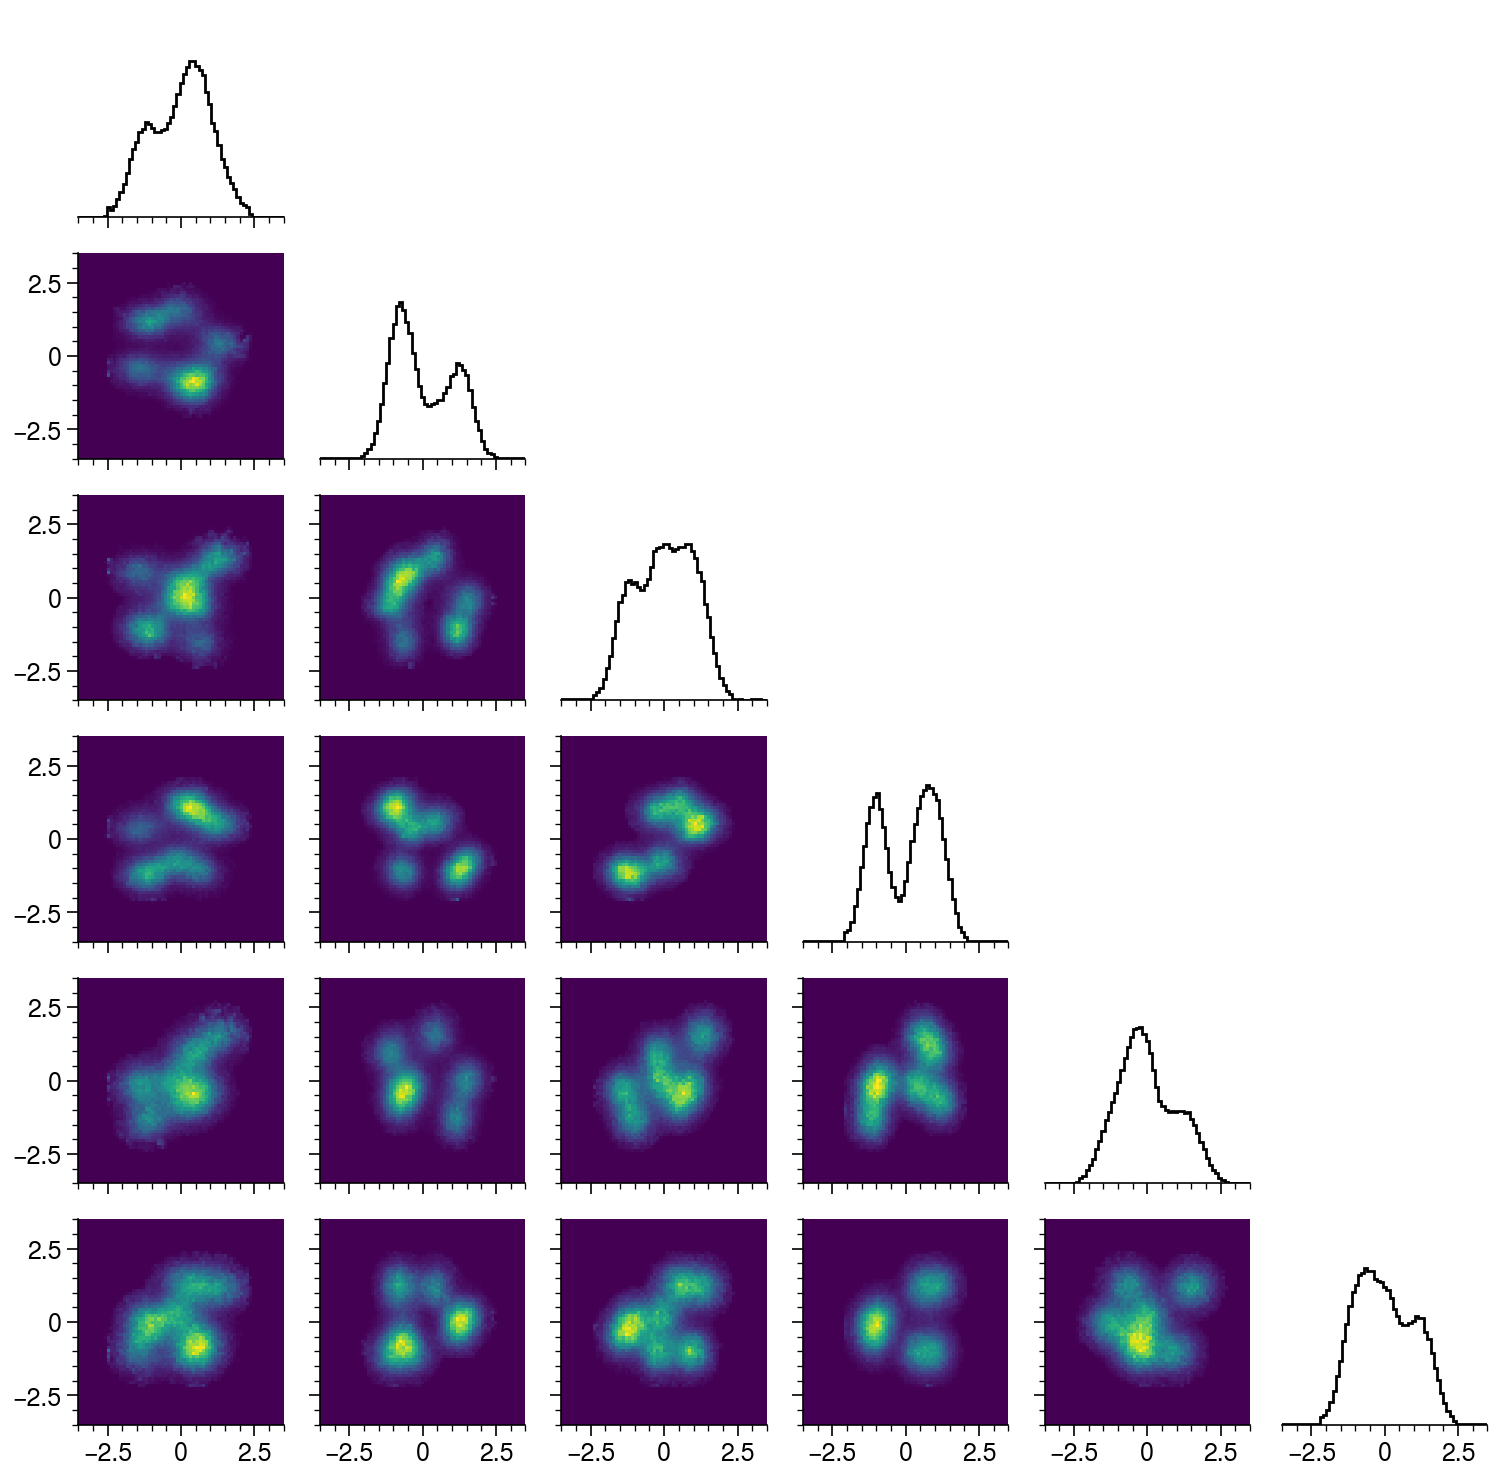

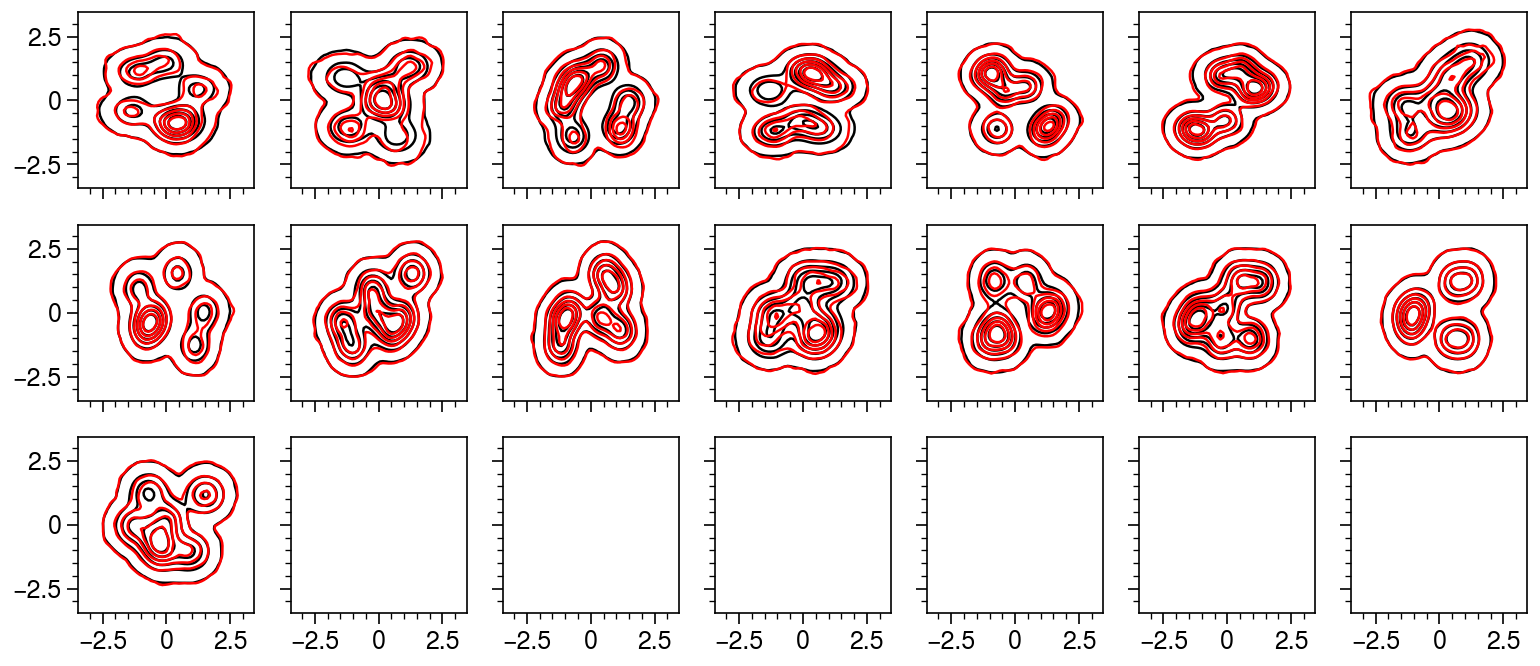

None
epoch = 2


  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 679.34it/s]

  9%|██████████▍                                                                                                     | 139/1499 [00:00<00:01, 697.19it/s]

 14%|███████████████▊                                                                                                | 211/1499 [00:00<00:01, 704.76it/s]

 19%|█████████████████████                                                                                           | 282/1499 [00:00<00:01, 700.61it/s]

 24%|██████████████████████████▎                                                                                     | 353/1499 [00:00<00:01, 701.67it/s]

 28%|███████████████████████████████▊                                                                                | 425/1499 [00:00<00:01, 706.08it/s]

 33%|█████████████████████████████████████▏                                                                          | 497/1499 [00:00<00:01, 708.69it/s]

 38%|██████████████████████████████████████████▌                                                                     | 569/1499 [00:00<00:01, 711.78it/s]

 43%|███████████████████████████████████████████████▉                                                                | 642/1499 [00:00<00:01, 714.33it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 714/1499 [00:01<00:01, 714.82it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 786/1499 [00:01<00:00, 715.62it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 858/1499 [00:01<00:00, 715.95it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 930/1499 [00:01<00:00, 717.03it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1002/1499 [00:01<00:00, 710.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1074/1499 [00:01<00:00, 706.39it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1145/1499 [00:01<00:00, 699.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1215/1499 [00:01<00:00, 694.10it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1287/1499 [00:01<00:00, 699.96it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1359/1499 [00:01<00:00, 705.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1431/1499 [00:02<00:00, 707.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 707.35it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 670.55it/s]

  9%|██████████▏                                                                                                     | 137/1499 [00:00<00:02, 680.78it/s]

 14%|███████████████▌                                                                                                | 209/1499 [00:00<00:01, 696.42it/s]

 19%|████████████████████▉                                                                                           | 281/1499 [00:00<00:01, 704.44it/s]

 23%|██████████████████████████▎                                                                                     | 352/1499 [00:00<00:01, 703.00it/s]

 28%|███████████████████████████████▌                                                                                | 423/1499 [00:00<00:01, 700.79it/s]

 33%|████████████████████████████████████▉                                                                           | 495/1499 [00:00<00:01, 706.58it/s]

 38%|██████████████████████████████████████████▎                                                                     | 567/1499 [00:00<00:01, 708.20it/s]

 43%|███████████████████████████████████████████████▋                                                                | 638/1499 [00:00<00:01, 705.44it/s]

 47%|█████████████████████████████████████████████████████                                                           | 710/1499 [00:01<00:01, 708.15it/s]

 52%|██████████████████████████████████████████████████████████▍                                                     | 782/1499 [00:01<00:01, 710.37it/s]

 57%|███████████████████████████████████████████████████████████████▊                                                | 854/1499 [00:01<00:00, 702.70it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                          | 926/1499 [00:01<00:00, 706.91it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                     | 998/1499 [00:01<00:00, 709.95it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1070/1499 [00:01<00:00, 710.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1142/1499 [00:01<00:00, 712.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1214/1499 [00:01<00:00, 708.58it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1285/1499 [00:01<00:00, 703.42it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1356/1499 [00:01<00:00, 705.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1427/1499 [00:02<00:00, 692.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1498/1499 [00:02<00:00, 696.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 702.60it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 701.93it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 687.98it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 695.04it/s]

 19%|█████████████████████▏                                                                                          | 284/1499 [00:00<00:01, 700.64it/s]

 24%|██████████████████████████▋                                                                                     | 357/1499 [00:00<00:01, 707.93it/s]

 29%|████████████████████████████████                                                                                | 429/1499 [00:00<00:01, 709.88it/s]

 33%|█████████████████████████████████████▍                                                                          | 501/1499 [00:00<00:01, 712.06it/s]

 38%|██████████████████████████████████████████▊                                                                     | 573/1499 [00:00<00:01, 707.15it/s]

 43%|████████████████████████████████████████████████                                                                | 644/1499 [00:00<00:01, 707.20it/s]

 48%|█████████████████████████████████████████████████████▍                                                          | 715/1499 [00:01<00:01, 707.62it/s]

 53%|██████████████████████████████████████████████████████████▊                                                     | 787/1499 [00:01<00:01, 708.46it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 858/1499 [00:01<00:00, 704.85it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 929/1499 [00:01<00:00, 703.57it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1000/1499 [00:01<00:00, 702.80it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1071/1499 [00:01<00:00, 694.50it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1143/1499 [00:01<00:00, 699.35it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1216/1499 [00:01<00:00, 705.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1287/1499 [00:01<00:00, 704.64it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1358/1499 [00:01<00:00, 704.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1429/1499 [00:02<00:00, 702.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 703.45it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 70/1499 [00:00<00:02, 691.82it/s]

  9%|██████████▌                                                                                                     | 141/1499 [00:00<00:01, 699.15it/s]

 14%|███████████████▊                                                                                                | 212/1499 [00:00<00:01, 701.80it/s]

 19%|█████████████████████▏                                                                                          | 284/1499 [00:00<00:01, 705.33it/s]

 24%|██████████████████████████▌                                                                                     | 355/1499 [00:00<00:01, 705.91it/s]

 28%|███████████████████████████████▉                                                                                | 427/1499 [00:00<00:01, 707.20it/s]

 33%|█████████████████████████████████████▎                                                                          | 499/1499 [00:00<00:01, 709.52it/s]

 38%|██████████████████████████████████████████▋                                                                     | 571/1499 [00:00<00:01, 711.57it/s]

 43%|████████████████████████████████████████████████                                                                | 643/1499 [00:00<00:01, 712.86it/s]

 48%|█████████████████████████████████████████████████████▍                                                          | 715/1499 [00:01<00:01, 710.95it/s]

 53%|██████████████████████████████████████████████████████████▊                                                     | 787/1499 [00:01<00:00, 712.62it/s]

 57%|████████████████████████████████████████████████████████████████▏                                               | 859/1499 [00:01<00:00, 709.66it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                          | 931/1499 [00:01<00:00, 711.27it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1003/1499 [00:01<00:00, 713.09it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1075/1499 [00:01<00:00, 714.02it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1147/1499 [00:01<00:00, 712.73it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1220/1499 [00:01<00:00, 715.43it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1293/1499 [00:01<00:00, 717.34it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1365/1499 [00:01<00:00, 715.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1437/1499 [00:02<00:00, 712.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 711.19it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 703.93it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 704.35it/s]

 14%|███████████████▉                                                                                                | 214/1499 [00:00<00:01, 707.35it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 703.75it/s]

 24%|██████████████████████████▋                                                                                     | 357/1499 [00:00<00:01, 706.89it/s]

 29%|███████████████████████████████▉                                                                                | 428/1499 [00:00<00:01, 707.28it/s]

 33%|█████████████████████████████████████▎                                                                          | 499/1499 [00:00<00:01, 693.14it/s]

 38%|██████████████████████████████████████████▌                                                                     | 569/1499 [00:00<00:01, 689.91it/s]

 43%|███████████████████████████████████████████████▋                                                                | 639/1499 [00:00<00:01, 658.90it/s]

 47%|████████████████████████████████████████████████████▋                                                           | 706/1499 [00:01<00:01, 647.36it/s]

 52%|█████████████████████████████████████████████████████████▉                                                      | 776/1499 [00:01<00:01, 660.26it/s]

 56%|███████████████████████████████████████████████████████████████▏                                                | 846/1499 [00:01<00:00, 669.16it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                           | 919/1499 [00:01<00:00, 684.27it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                      | 992/1499 [00:01<00:00, 695.40it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1062/1499 [00:01<00:00, 696.36it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1132/1499 [00:01<00:00, 696.29it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1205/1499 [00:01<00:00, 704.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1277/1499 [00:01<00:00, 708.90it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1349/1499 [00:01<00:00, 711.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1421/1499 [00:02<00:00, 714.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1494/1499 [00:02<00:00, 717.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 695.53it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▍                                                                                                           | 72/1499 [00:00<00:02, 713.16it/s]

 10%|██████████▊                                                                                                     | 144/1499 [00:00<00:01, 711.85it/s]

 14%|████████████████▏                                                                                               | 216/1499 [00:00<00:01, 707.55it/s]

 19%|█████████████████████▌                                                                                          | 288/1499 [00:00<00:01, 710.34it/s]

 24%|██████████████████████████▉                                                                                     | 360/1499 [00:00<00:01, 702.13it/s]

 29%|████████████████████████████████▎                                                                               | 432/1499 [00:00<00:01, 706.94it/s]

 34%|█████████████████████████████████████▌                                                                          | 503/1499 [00:00<00:01, 701.84it/s]

 38%|██████████████████████████████████████████▉                                                                     | 575/1499 [00:00<00:01, 707.50it/s]

 43%|████████████████████████████████████████████████▍                                                               | 648/1499 [00:00<00:01, 711.38it/s]

 48%|█████████████████████████████████████████████████████▊                                                          | 720/1499 [00:01<00:01, 709.36it/s]

 53%|███████████████████████████████████████████████████████████▏                                                    | 792/1499 [00:01<00:00, 709.87it/s]

 58%|████████████████████████████████████████████████████████████████▋                                               | 865/1499 [00:01<00:00, 713.61it/s]

 63%|██████████████████████████████████████████████████████████████████████                                          | 937/1499 [00:01<00:00, 713.64it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1009/1499 [00:01<00:00, 707.08it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1080/1499 [00:01<00:00, 700.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1151/1499 [00:01<00:00, 702.67it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1223/1499 [00:01<00:00, 707.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1295/1499 [00:01<00:00, 710.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1367/1499 [00:01<00:00, 713.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1439/1499 [00:02<00:00, 714.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 709.70it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 706.64it/s]

 10%|██████████▋                                                                                                     | 143/1499 [00:00<00:01, 708.52it/s]

 14%|████████████████                                                                                                | 215/1499 [00:00<00:01, 710.53it/s]

 19%|█████████████████████▍                                                                                          | 287/1499 [00:00<00:01, 708.72it/s]

 24%|██████████████████████████▋                                                                                     | 358/1499 [00:00<00:01, 707.64it/s]

 29%|████████████████████████████████▏                                                                               | 430/1499 [00:00<00:01, 710.53it/s]

 33%|█████████████████████████████████████▌                                                                          | 502/1499 [00:00<00:01, 712.81it/s]

 38%|██████████████████████████████████████████▉                                                                     | 574/1499 [00:00<00:01, 712.91it/s]

 43%|████████████████████████████████████████████████▎                                                               | 646/1499 [00:00<00:01, 712.95it/s]

 48%|█████████████████████████████████████████████████████▋                                                          | 718/1499 [00:01<00:01, 713.89it/s]

 53%|███████████████████████████████████████████████████████████                                                     | 790/1499 [00:01<00:00, 714.15it/s]

 58%|████████████████████████████████████████████████████████████████▍                                               | 863/1499 [00:01<00:00, 716.37it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                          | 936/1499 [00:01<00:00, 718.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1009/1499 [00:01<00:00, 719.66it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1082/1499 [00:01<00:00, 720.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1155/1499 [00:01<00:00, 718.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1227/1499 [00:01<00:00, 718.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1299/1499 [00:01<00:00, 717.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1371/1499 [00:01<00:00, 714.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1443/1499 [00:02<00:00, 709.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 713.29it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 701.36it/s]

 10%|██████████▋                                                                                                     | 143/1499 [00:00<00:01, 706.80it/s]

 14%|███████████████▉                                                                                                | 214/1499 [00:00<00:01, 707.69it/s]

 19%|█████████████████████▎                                                                                          | 286/1499 [00:00<00:01, 711.62it/s]

 24%|██████████████████████████▋                                                                                     | 358/1499 [00:00<00:01, 708.73it/s]

 29%|████████████████████████████████▏                                                                               | 430/1499 [00:00<00:01, 709.52it/s]

 33%|█████████████████████████████████████▌                                                                          | 502/1499 [00:00<00:01, 710.87it/s]

 38%|██████████████████████████████████████████▉                                                                     | 574/1499 [00:00<00:01, 709.46it/s]

 43%|████████████████████████████████████████████████▎                                                               | 646/1499 [00:00<00:01, 710.17it/s]

 48%|█████████████████████████████████████████████████████▋                                                          | 718/1499 [00:01<00:01, 710.22it/s]

 53%|███████████████████████████████████████████████████████████                                                     | 790/1499 [00:01<00:00, 711.76it/s]

 58%|████████████████████████████████████████████████████████████████▍                                               | 862/1499 [00:01<00:00, 712.84it/s]

 62%|█████████████████████████████████████████████████████████████████████▊                                          | 934/1499 [00:01<00:00, 713.39it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1006/1499 [00:01<00:00, 711.31it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1078/1499 [00:01<00:00, 713.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1150/1499 [00:01<00:00, 715.11it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1222/1499 [00:01<00:00, 716.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1294/1499 [00:01<00:00, 715.12it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1366/1499 [00:01<00:00, 716.13it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1439/1499 [00:02<00:00, 717.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 712.49it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 704.64it/s]

 10%|██████████▋                                                                                                     | 143/1499 [00:00<00:01, 707.57it/s]

 14%|████████████████                                                                                                | 215/1499 [00:00<00:01, 712.27it/s]

 19%|█████████████████████▍                                                                                          | 287/1499 [00:00<00:01, 714.50it/s]

 24%|██████████████████████████▊                                                                                     | 359/1499 [00:00<00:01, 715.78it/s]

 29%|████████████████████████████████▏                                                                               | 431/1499 [00:00<00:01, 710.72it/s]

 34%|█████████████████████████████████████▌                                                                          | 503/1499 [00:00<00:01, 711.63it/s]

 38%|██████████████████████████████████████████▉                                                                     | 575/1499 [00:00<00:01, 709.90it/s]

 43%|████████████████████████████████████████████████▎                                                               | 646/1499 [00:00<00:01, 702.22it/s]

 48%|█████████████████████████████████████████████████████▋                                                          | 718/1499 [00:01<00:01, 704.83it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 789/1499 [00:01<00:01, 700.47it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 861/1499 [00:01<00:00, 704.11it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                          | 932/1499 [00:01<00:00, 699.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1002/1499 [00:01<00:00, 695.63it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1073/1499 [00:01<00:00, 697.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1145/1499 [00:01<00:00, 703.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1217/1499 [00:01<00:00, 706.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1289/1499 [00:01<00:00, 709.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1361/1499 [00:01<00:00, 710.45it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1433/1499 [00:02<00:00, 711.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 707.58it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 701.56it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 694.18it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 699.30it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 706.01it/s]

 24%|██████████████████████████▌                                                                                     | 356/1499 [00:00<00:01, 707.20it/s]

 28%|███████████████████████████████▉                                                                                | 427/1499 [00:00<00:01, 706.08it/s]

 33%|█████████████████████████████████████▎                                                                          | 499/1499 [00:00<00:01, 708.57it/s]

 38%|██████████████████████████████████████████▋                                                                     | 571/1499 [00:00<00:01, 710.90it/s]

 43%|████████████████████████████████████████████████                                                                | 643/1499 [00:00<00:01, 711.24it/s]

 48%|█████████████████████████████████████████████████████▍                                                          | 715/1499 [00:01<00:01, 700.13it/s]

 53%|██████████████████████████████████████████████████████████▊                                                     | 787/1499 [00:01<00:01, 705.22it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 858/1499 [00:01<00:00, 704.61it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 930/1499 [00:01<00:00, 706.98it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1003/1499 [00:01<00:00, 711.00it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1076/1499 [00:01<00:00, 714.36it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1148/1499 [00:01<00:00, 714.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1220/1499 [00:01<00:00, 712.57it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1292/1499 [00:01<00:00, 712.39it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1364/1499 [00:01<00:00, 713.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1437/1499 [00:02<00:00, 715.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 709.79it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 704.90it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 702.84it/s]

 14%|███████████████▉                                                                                                | 214/1499 [00:00<00:01, 706.71it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 706.97it/s]

 24%|██████████████████████████▋                                                                                     | 357/1499 [00:00<00:01, 709.34it/s]

 29%|███████████████████████████████▉                                                                                | 428/1499 [00:00<00:01, 705.48it/s]

 33%|█████████████████████████████████████▎                                                                          | 499/1499 [00:00<00:01, 705.14it/s]

 38%|██████████████████████████████████████████▌                                                                     | 570/1499 [00:00<00:01, 705.40it/s]

 43%|███████████████████████████████████████████████▉                                                                | 642/1499 [00:00<00:01, 708.27it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 713/1499 [00:01<00:01, 708.30it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 785/1499 [00:01<00:01, 709.87it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 857/1499 [00:01<00:00, 709.96it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 929/1499 [00:01<00:00, 712.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1001/1499 [00:01<00:00, 713.60it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1073/1499 [00:01<00:00, 714.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1145/1499 [00:01<00:00, 712.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1217/1499 [00:01<00:00, 713.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1289/1499 [00:01<00:00, 713.74it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1361/1499 [00:01<00:00, 715.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1433/1499 [00:02<00:00, 714.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 710.72it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▍                                                                                                           | 72/1499 [00:00<00:02, 710.21it/s]

 10%|██████████▊                                                                                                     | 144/1499 [00:00<00:01, 709.55it/s]

 14%|████████████████▏                                                                                               | 216/1499 [00:00<00:01, 711.25it/s]

 19%|█████████████████████▌                                                                                          | 288/1499 [00:00<00:01, 711.61it/s]

 24%|██████████████████████████▉                                                                                     | 360/1499 [00:00<00:01, 697.25it/s]

 29%|████████████████████████████████▏                                                                               | 430/1499 [00:00<00:01, 695.21it/s]

 33%|█████████████████████████████████████▎                                                                          | 500/1499 [00:00<00:01, 690.92it/s]

 38%|██████████████████████████████████████████▋                                                                     | 572/1499 [00:00<00:01, 697.54it/s]

 43%|████████████████████████████████████████████████                                                                | 643/1499 [00:00<00:01, 699.50it/s]

 48%|█████████████████████████████████████████████████████▍                                                          | 715/1499 [00:01<00:01, 703.60it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 788/1499 [00:01<00:01, 709.43it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 861/1499 [00:01<00:00, 713.06it/s]

 62%|█████████████████████████████████████████████████████████████████████▊                                          | 934/1499 [00:01<00:00, 715.95it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1006/1499 [00:01<00:00, 715.40it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1078/1499 [00:01<00:00, 703.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1151/1499 [00:01<00:00, 708.27it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1222/1499 [00:01<00:00, 699.23it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1293/1499 [00:01<00:00, 701.24it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1364/1499 [00:01<00:00, 690.95it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1437/1499 [00:02<00:00, 699.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 703.93it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 706.99it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 707.19it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 690.42it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 699.77it/s]

 24%|██████████████████████████▋                                                                                     | 357/1499 [00:00<00:01, 705.00it/s]

 29%|████████████████████████████████                                                                                | 429/1499 [00:00<00:01, 707.83it/s]

 33%|█████████████████████████████████████▍                                                                          | 501/1499 [00:00<00:01, 709.64it/s]

 38%|██████████████████████████████████████████▋                                                                     | 572/1499 [00:00<00:01, 707.76it/s]

 43%|████████████████████████████████████████████████                                                                | 644/1499 [00:00<00:01, 710.07it/s]

 48%|█████████████████████████████████████████████████████▍                                                          | 716/1499 [00:01<00:01, 712.00it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 788/1499 [00:01<00:00, 712.56it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 860/1499 [00:01<00:00, 711.13it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                          | 932/1499 [00:01<00:00, 710.45it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1004/1499 [00:01<00:00, 711.20it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1076/1499 [00:01<00:00, 712.34it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1148/1499 [00:01<00:00, 708.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1220/1499 [00:01<00:00, 709.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1292/1499 [00:01<00:00, 711.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1364/1499 [00:01<00:00, 713.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1436/1499 [00:02<00:00, 714.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 709.81it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 688.62it/s]

  9%|██████████▍                                                                                                     | 139/1499 [00:00<00:01, 690.22it/s]

 14%|███████████████▋                                                                                                | 210/1499 [00:00<00:01, 696.60it/s]

 19%|█████████████████████                                                                                           | 282/1499 [00:00<00:01, 704.88it/s]

 24%|██████████████████████████▌                                                                                     | 355/1499 [00:00<00:01, 710.29it/s]

 28%|███████████████████████████████▉                                                                                | 427/1499 [00:00<00:01, 713.36it/s]

 33%|█████████████████████████████████████▎                                                                          | 499/1499 [00:00<00:01, 715.23it/s]

 38%|██████████████████████████████████████████▋                                                                     | 572/1499 [00:00<00:01, 717.01it/s]

 43%|████████████████████████████████████████████████▏                                                               | 645/1499 [00:00<00:01, 717.82it/s]

 48%|█████████████████████████████████████████████████████▌                                                          | 717/1499 [00:01<00:01, 713.31it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 789/1499 [00:01<00:01, 709.64it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 861/1499 [00:01<00:00, 710.83it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                          | 933/1499 [00:01<00:00, 708.24it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1004/1499 [00:01<00:00, 705.60it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1075/1499 [00:01<00:00, 703.24it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1147/1499 [00:01<00:00, 706.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1218/1499 [00:01<00:00, 706.41it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1289/1499 [00:01<00:00, 704.04it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1361/1499 [00:01<00:00, 706.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1434/1499 [00:02<00:00, 710.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 708.73it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 671.77it/s]

  9%|██████████▏                                                                                                     | 136/1499 [00:00<00:02, 674.08it/s]

 14%|███████████████▎                                                                                                | 205/1499 [00:00<00:01, 677.79it/s]

 18%|████████████████████▍                                                                                           | 274/1499 [00:00<00:01, 678.80it/s]

 23%|█████████████████████████▊                                                                                      | 345/1499 [00:00<00:01, 688.37it/s]

 28%|██████████████████████████████▉                                                                                 | 414/1499 [00:00<00:01, 684.77it/s]

 32%|████████████████████████████████████▏                                                                           | 485/1499 [00:00<00:01, 690.45it/s]

 37%|█████████████████████████████████████████▍                                                                      | 555/1499 [00:00<00:01, 689.64it/s]

 42%|██████████████████████████████████████████████▊                                                                 | 627/1499 [00:00<00:01, 696.13it/s]

 47%|████████████████████████████████████████████████████▏                                                           | 699/1499 [00:01<00:01, 702.65it/s]

 52%|█████████████████████████████████████████████████████████▋                                                      | 772/1499 [00:01<00:01, 708.12it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                 | 843/1499 [00:01<00:00, 708.67it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                           | 915/1499 [00:01<00:00, 711.34it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                      | 987/1499 [00:01<00:00, 710.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1059/1499 [00:01<00:00, 711.51it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1132/1499 [00:01<00:00, 714.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1205/1499 [00:01<00:00, 716.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1277/1499 [00:01<00:00, 712.37it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1349/1499 [00:01<00:00, 714.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1421/1499 [00:02<00:00, 711.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1494/1499 [00:02<00:00, 714.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 703.12it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 700.59it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 693.90it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 696.91it/s]

 19%|█████████████████████▏                                                                                          | 284/1499 [00:00<00:01, 701.77it/s]

 24%|██████████████████████████▌                                                                                     | 355/1499 [00:00<00:01, 704.11it/s]

 28%|███████████████████████████████▊                                                                                | 426/1499 [00:00<00:01, 702.71it/s]

 33%|█████████████████████████████████████▏                                                                          | 498/1499 [00:00<00:01, 706.31it/s]

 38%|██████████████████████████████████████████▌                                                                     | 570/1499 [00:00<00:01, 709.33it/s]

 43%|███████████████████████████████████████████████▉                                                                | 642/1499 [00:00<00:01, 710.17it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 714/1499 [00:01<00:01, 711.96it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 786/1499 [00:01<00:01, 711.01it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 858/1499 [00:01<00:00, 708.15it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 930/1499 [00:01<00:00, 709.51it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1002/1499 [00:01<00:00, 710.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1074/1499 [00:01<00:00, 709.47it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1145/1499 [00:01<00:00, 709.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1217/1499 [00:01<00:00, 711.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1289/1499 [00:01<00:00, 713.66it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1361/1499 [00:01<00:00, 712.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1433/1499 [00:02<00:00, 712.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 709.19it/s]

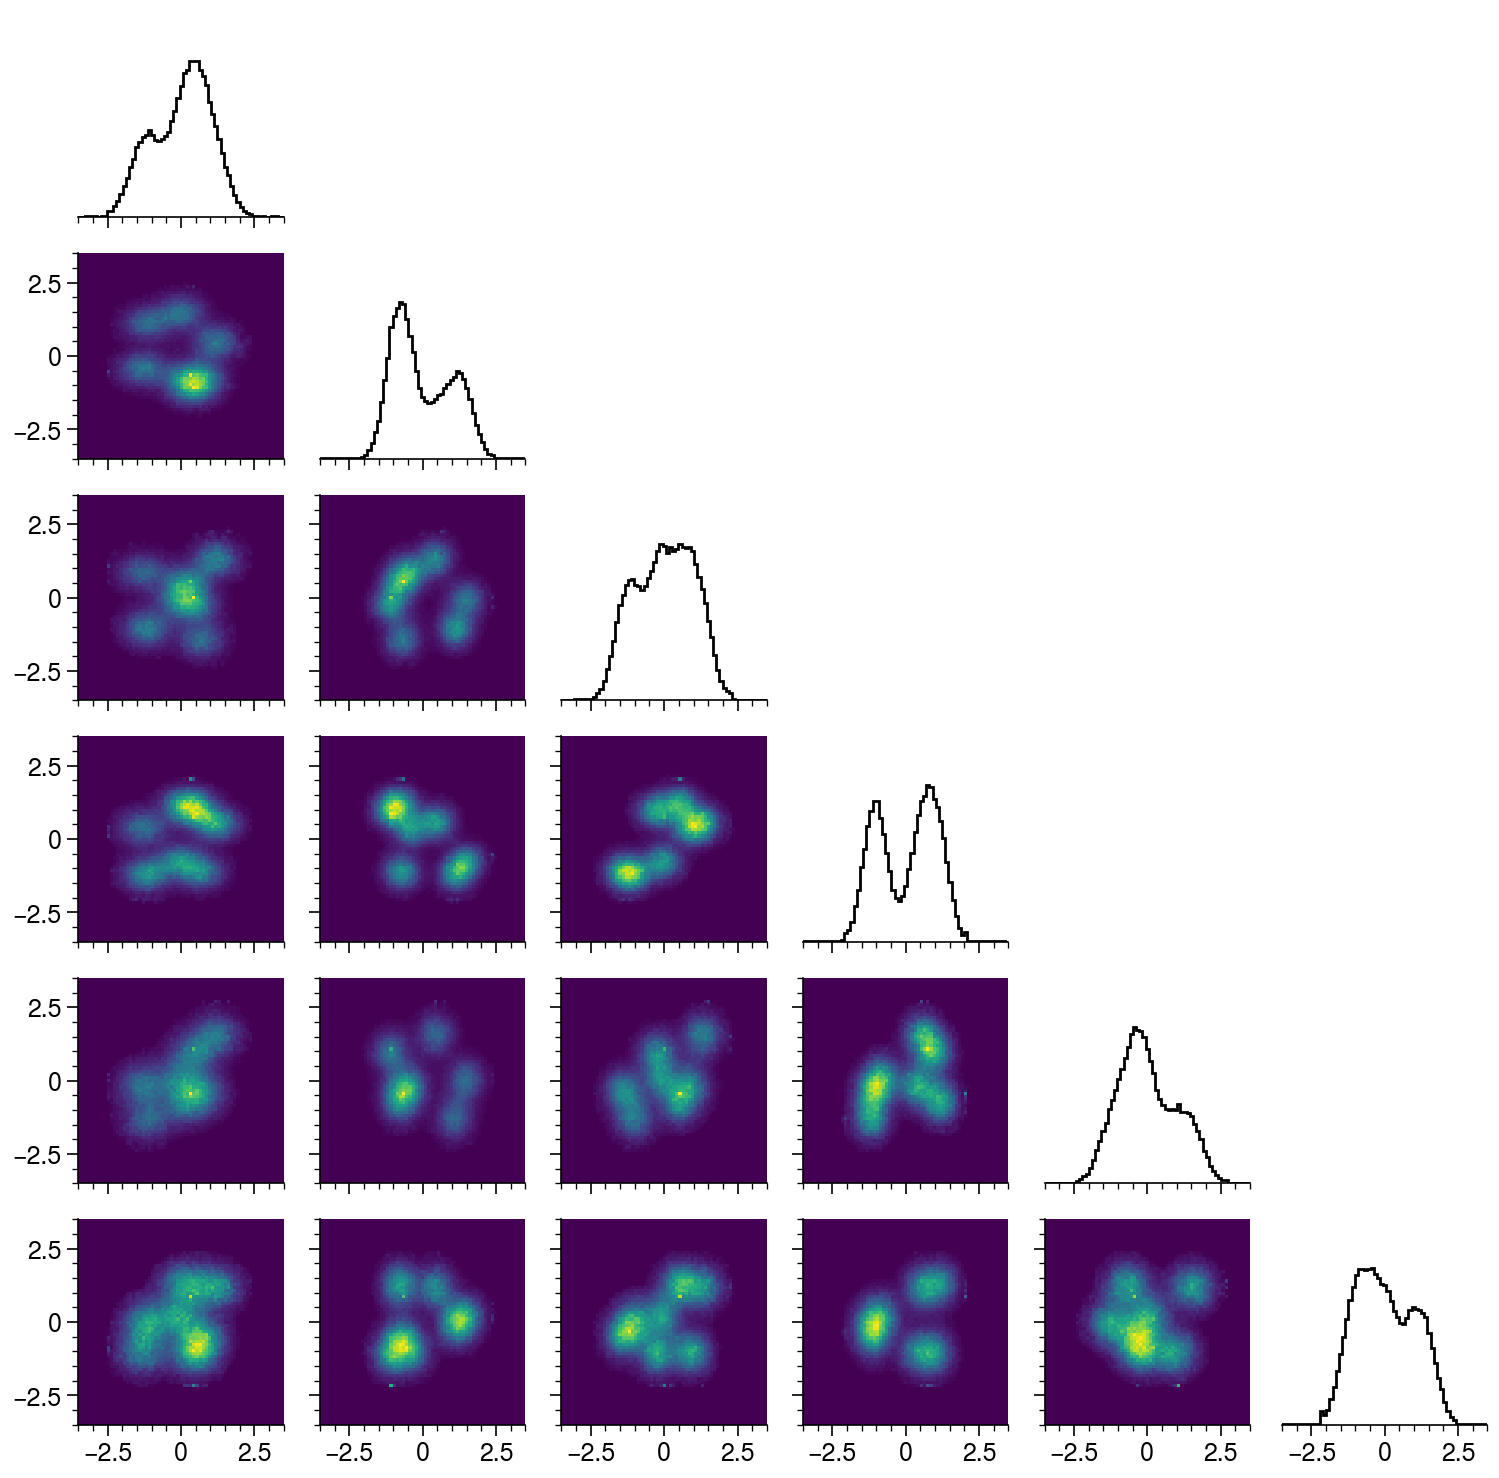

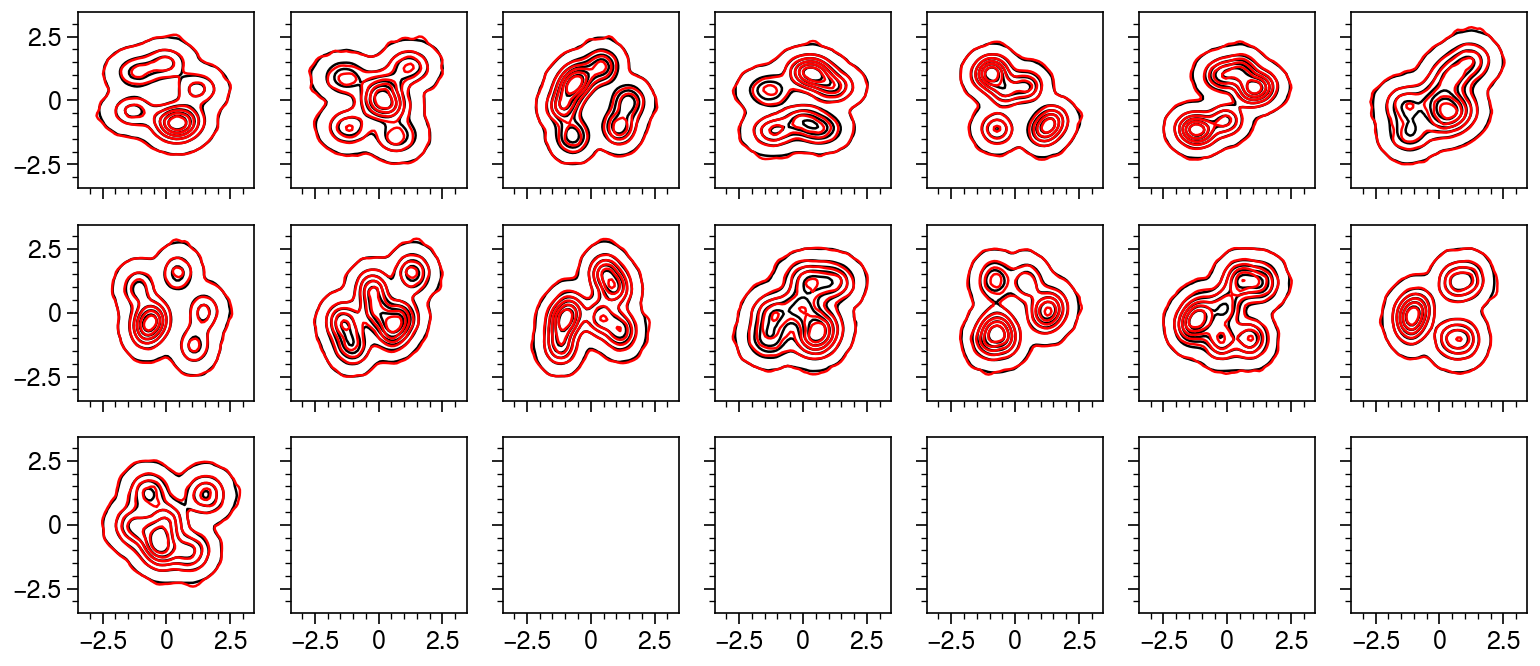

None
epoch = 3


  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 684.37it/s]

  9%|██████████▎                                                                                                     | 138/1499 [00:00<00:01, 681.86it/s]

 14%|███████████████▌                                                                                                | 208/1499 [00:00<00:01, 686.28it/s]

 19%|████████████████████▊                                                                                           | 278/1499 [00:00<00:01, 690.02it/s]

 23%|██████████████████████████                                                                                      | 348/1499 [00:00<00:01, 690.05it/s]

 28%|███████████████████████████████▍                                                                                | 420/1499 [00:00<00:01, 697.89it/s]

 33%|████████████████████████████████████▊                                                                           | 492/1499 [00:00<00:01, 705.06it/s]

 38%|██████████████████████████████████████████▏                                                                     | 565/1499 [00:00<00:01, 710.34it/s]

 43%|███████████████████████████████████████████████▋                                                                | 638/1499 [00:00<00:01, 713.73it/s]

 47%|█████████████████████████████████████████████████████                                                           | 710/1499 [00:01<00:01, 713.90it/s]

 52%|██████████████████████████████████████████████████████████▍                                                     | 782/1499 [00:01<00:01, 713.06it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                | 855/1499 [00:01<00:00, 715.74it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                          | 928/1499 [00:01<00:00, 718.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1000/1499 [00:01<00:00, 717.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1073/1499 [00:01<00:00, 719.01it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1146/1499 [00:01<00:00, 720.57it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1219/1499 [00:01<00:00, 716.44it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1292/1499 [00:01<00:00, 718.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1365/1499 [00:01<00:00, 720.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1438/1499 [00:02<00:00, 713.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 710.78it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 674.48it/s]

  9%|██████████▏                                                                                                     | 137/1499 [00:00<00:02, 679.36it/s]

 14%|███████████████▎                                                                                                | 205/1499 [00:00<00:01, 676.08it/s]

 18%|████████████████████▋                                                                                           | 277/1499 [00:00<00:01, 692.23it/s]

 23%|██████████████████████████▏                                                                                     | 350/1499 [00:00<00:01, 702.50it/s]

 28%|███████████████████████████████▍                                                                                | 421/1499 [00:00<00:01, 701.88it/s]

 33%|████████████████████████████████████▊                                                                           | 493/1499 [00:00<00:01, 706.95it/s]

 38%|██████████████████████████████████████████▎                                                                     | 566/1499 [00:00<00:01, 712.30it/s]

 43%|███████████████████████████████████████████████▋                                                                | 638/1499 [00:00<00:01, 711.54it/s]

 47%|█████████████████████████████████████████████████████                                                           | 710/1499 [00:01<00:01, 710.26it/s]

 52%|██████████████████████████████████████████████████████████▌                                                     | 783/1499 [00:01<00:01, 713.51it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                | 856/1499 [00:01<00:00, 716.27it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                          | 928/1499 [00:01<00:00, 712.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1000/1499 [00:01<00:00, 714.39it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1073/1499 [00:01<00:00, 717.39it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1146/1499 [00:01<00:00, 717.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1218/1499 [00:01<00:00, 718.29it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1291/1499 [00:01<00:00, 720.27it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1364/1499 [00:01<00:00, 721.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1437/1499 [00:02<00:00, 722.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 711.95it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 686.77it/s]

  9%|██████████▌                                                                                                     | 141/1499 [00:00<00:01, 703.67it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 709.13it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 712.89it/s]

 24%|██████████████████████████▋                                                                                     | 358/1499 [00:00<00:01, 715.48it/s]

 29%|████████████████████████████████▏                                                                               | 430/1499 [00:00<00:01, 716.85it/s]

 33%|█████████████████████████████████████▌                                                                          | 502/1499 [00:00<00:01, 708.71it/s]

 38%|██████████████████████████████████████████▉                                                                     | 574/1499 [00:00<00:01, 711.95it/s]

 43%|████████████████████████████████████████████████▎                                                               | 647/1499 [00:00<00:01, 715.58it/s]

 48%|█████████████████████████████████████████████████████▊                                                          | 720/1499 [00:01<00:01, 716.59it/s]

 53%|███████████████████████████████████████████████████████████▏                                                    | 792/1499 [00:01<00:00, 711.58it/s]

 58%|████████████████████████████████████████████████████████████████▌                                               | 864/1499 [00:01<00:00, 714.07it/s]

 63%|██████████████████████████████████████████████████████████████████████                                          | 937/1499 [00:01<00:00, 716.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1010/1499 [00:01<00:00, 718.05it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1082/1499 [00:01<00:00, 710.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1154/1499 [00:01<00:00, 711.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1226/1499 [00:01<00:00, 711.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1298/1499 [00:01<00:00, 712.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1370/1499 [00:01<00:00, 714.22it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1443/1499 [00:02<00:00, 717.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 713.80it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 702.77it/s]

 10%|██████████▋                                                                                                     | 143/1499 [00:00<00:01, 709.72it/s]

 14%|███████████████▉                                                                                                | 214/1499 [00:00<00:01, 708.73it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 705.26it/s]

 24%|██████████████████████████▋                                                                                     | 357/1499 [00:00<00:01, 709.00it/s]

 29%|████████████████████████████████                                                                                | 429/1499 [00:00<00:01, 711.35it/s]

 33%|█████████████████████████████████████▌                                                                          | 502/1499 [00:00<00:01, 714.72it/s]

 38%|██████████████████████████████████████████▉                                                                     | 575/1499 [00:00<00:01, 717.29it/s]

 43%|████████████████████████████████████████████████▍                                                               | 648/1499 [00:00<00:01, 718.98it/s]

 48%|█████████████████████████████████████████████████████▊                                                          | 721/1499 [00:01<00:01, 720.54it/s]

 53%|███████████████████████████████████████████████████████████▎                                                    | 794/1499 [00:01<00:00, 721.14it/s]

 58%|████████████████████████████████████████████████████████████████▊                                               | 867/1499 [00:01<00:00, 714.44it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                         | 939/1499 [00:01<00:00, 712.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1011/1499 [00:01<00:00, 711.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1083/1499 [00:01<00:00, 707.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1156/1499 [00:01<00:00, 712.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1229/1499 [00:01<00:00, 715.29it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1301/1499 [00:01<00:00, 703.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1372/1499 [00:01<00:00, 701.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1443/1499 [00:02<00:00, 692.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 707.42it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  4%|████▉                                                                                                            | 66/1499 [00:00<00:02, 658.51it/s]

  9%|██████████▏                                                                                                     | 137/1499 [00:00<00:01, 687.97it/s]

 14%|███████████████▍                                                                                                | 206/1499 [00:00<00:01, 682.47it/s]

 19%|████████████████████▊                                                                                           | 278/1499 [00:00<00:01, 694.40it/s]

 23%|██████████████████████████▏                                                                                     | 350/1499 [00:00<00:01, 701.10it/s]

 28%|███████████████████████████████▍                                                                                | 421/1499 [00:00<00:01, 703.46it/s]

 33%|████████████████████████████████████▊                                                                           | 493/1499 [00:00<00:01, 708.30it/s]

 38%|██████████████████████████████████████████▏                                                                     | 564/1499 [00:00<00:01, 697.03it/s]

 42%|███████████████████████████████████████████████▎                                                                | 634/1499 [00:00<00:01, 692.81it/s]

 47%|████████████████████████████████████████████████████▌                                                           | 704/1499 [00:01<00:01, 687.69it/s]

 52%|█████████████████████████████████████████████████████████▊                                                      | 774/1499 [00:01<00:01, 688.94it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                 | 843/1499 [00:01<00:00, 686.04it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                           | 912/1499 [00:01<00:00, 682.94it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                      | 981/1499 [00:01<00:00, 682.30it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1050/1499 [00:01<00:00, 680.44it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1120/1499 [00:01<00:00, 686.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1192/1499 [00:01<00:00, 696.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1263/1499 [00:01<00:00, 699.63it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1335/1499 [00:01<00:00, 703.24it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1407/1499 [00:02<00:00, 707.31it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1479/1499 [00:02<00:00, 710.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 695.50it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 701.48it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 697.78it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 702.17it/s]

 19%|█████████████████████▎                                                                                          | 285/1499 [00:00<00:01, 707.01it/s]

 24%|██████████████████████████▋                                                                                     | 357/1499 [00:00<00:01, 710.04it/s]

 29%|████████████████████████████████                                                                                | 429/1499 [00:00<00:01, 712.30it/s]

 33%|█████████████████████████████████████▍                                                                          | 501/1499 [00:00<00:01, 714.05it/s]

 38%|██████████████████████████████████████████▊                                                                     | 573/1499 [00:00<00:01, 715.02it/s]

 43%|████████████████████████████████████████████████▏                                                               | 645/1499 [00:00<00:01, 715.83it/s]

 48%|█████████████████████████████████████████████████████▌                                                          | 717/1499 [00:01<00:01, 710.10it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 789/1499 [00:01<00:00, 712.37it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 861/1499 [00:01<00:00, 706.17it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                          | 932/1499 [00:01<00:00, 704.27it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1003/1499 [00:01<00:00, 704.32it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1076/1499 [00:01<00:00, 709.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1149/1499 [00:01<00:00, 713.69it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1222/1499 [00:01<00:00, 715.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1294/1499 [00:01<00:00, 716.37it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1366/1499 [00:01<00:00, 717.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1439/1499 [00:02<00:00, 719.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 712.32it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 703.99it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 706.34it/s]

 14%|███████████████▉                                                                                                | 213/1499 [00:00<00:01, 693.99it/s]

 19%|█████████████████████▏                                                                                          | 283/1499 [00:00<00:01, 690.24it/s]

 24%|██████████████████████████▎                                                                                     | 353/1499 [00:00<00:01, 691.72it/s]

 28%|███████████████████████████████▌                                                                                | 423/1499 [00:00<00:01, 691.28it/s]

 33%|████████████████████████████████████▉                                                                           | 495/1499 [00:00<00:01, 699.62it/s]

 38%|██████████████████████████████████████████▎                                                                     | 567/1499 [00:00<00:01, 705.98it/s]

 43%|███████████████████████████████████████████████▊                                                                | 640/1499 [00:00<00:01, 710.67it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 713/1499 [00:01<00:01, 713.80it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 786/1499 [00:01<00:00, 716.73it/s]

 57%|████████████████████████████████████████████████████████████████▏                                               | 859/1499 [00:01<00:00, 718.26it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                          | 932/1499 [00:01<00:00, 720.36it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1005/1499 [00:01<00:00, 721.76it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1078/1499 [00:01<00:00, 715.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1150/1499 [00:01<00:00, 697.58it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1222/1499 [00:01<00:00, 701.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1293/1499 [00:01<00:00, 701.35it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1366/1499 [00:01<00:00, 707.11it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1439/1499 [00:02<00:00, 712.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 708.05it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▍                                                                                                           | 72/1499 [00:00<00:02, 711.07it/s]

 10%|██████████▊                                                                                                     | 144/1499 [00:00<00:01, 710.96it/s]

 14%|████████████████▏                                                                                               | 216/1499 [00:00<00:01, 712.31it/s]

 19%|█████████████████████▌                                                                                          | 288/1499 [00:00<00:01, 712.16it/s]

 24%|██████████████████████████▉                                                                                     | 360/1499 [00:00<00:01, 712.76it/s]

 29%|████████████████████████████████▎                                                                               | 432/1499 [00:00<00:01, 712.33it/s]

 34%|█████████████████████████████████████▋                                                                          | 504/1499 [00:00<00:01, 713.96it/s]

 38%|███████████████████████████████████████████                                                                     | 576/1499 [00:00<00:01, 715.23it/s]

 43%|████████████████████████████████████████████████▍                                                               | 648/1499 [00:00<00:01, 715.02it/s]

 48%|█████████████████████████████████████████████████████▊                                                          | 720/1499 [00:01<00:01, 714.94it/s]

 53%|███████████████████████████████████████████████████████████▏                                                    | 792/1499 [00:01<00:00, 709.77it/s]

 58%|████████████████████████████████████████████████████████████████▌                                               | 864/1499 [00:01<00:00, 711.33it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                          | 936/1499 [00:01<00:00, 710.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1008/1499 [00:01<00:00, 698.38it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1080/1499 [00:01<00:00, 702.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1152/1499 [00:01<00:00, 706.66it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1224/1499 [00:01<00:00, 709.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1296/1499 [00:01<00:00, 711.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1368/1499 [00:01<00:00, 713.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1440/1499 [00:02<00:00, 715.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 711.60it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▍                                                                                                           | 72/1499 [00:00<00:01, 714.93it/s]

 10%|██████████▊                                                                                                     | 144/1499 [00:00<00:01, 714.81it/s]

 14%|████████████████▏                                                                                               | 216/1499 [00:00<00:01, 711.98it/s]

 19%|█████████████████████▌                                                                                          | 288/1499 [00:00<00:01, 714.86it/s]

 24%|██████████████████████████▉                                                                                     | 360/1499 [00:00<00:01, 715.18it/s]

 29%|████████████████████████████████▎                                                                               | 432/1499 [00:00<00:01, 712.87it/s]

 34%|█████████████████████████████████████▋                                                                          | 504/1499 [00:00<00:01, 712.85it/s]

 38%|███████████████████████████████████████████                                                                     | 576/1499 [00:00<00:01, 713.72it/s]

 43%|████████████████████████████████████████████████▍                                                               | 648/1499 [00:00<00:01, 714.40it/s]

 48%|█████████████████████████████████████████████████████▊                                                          | 720/1499 [00:01<00:01, 704.41it/s]

 53%|███████████████████████████████████████████████████████████                                                     | 791/1499 [00:01<00:01, 696.45it/s]

 58%|████████████████████████████████████████████████████████████████▍                                               | 863/1499 [00:01<00:00, 701.65it/s]

 62%|█████████████████████████████████████████████████████████████████████▊                                          | 934/1499 [00:01<00:00, 694.25it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1004/1499 [00:01<00:00, 677.10it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1073/1499 [00:01<00:00, 679.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1141/1499 [00:01<00:00, 662.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1208/1499 [00:01<00:00, 663.14it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1275/1499 [00:01<00:00, 657.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1341/1499 [00:01<00:00, 653.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1407/1499 [00:02<00:00, 648.97it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1474/1499 [00:02<00:00, 652.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 683.85it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 682.62it/s]

  9%|██████████▎                                                                                                     | 138/1499 [00:00<00:01, 686.41it/s]

 14%|███████████████▍                                                                                                | 207/1499 [00:00<00:01, 677.58it/s]

 18%|████████████████████▋                                                                                           | 277/1499 [00:00<00:01, 685.71it/s]

 23%|██████████████████████████                                                                                      | 348/1499 [00:00<00:01, 693.95it/s]

 28%|███████████████████████████████▏                                                                                | 418/1499 [00:00<00:01, 694.13it/s]

 33%|████████████████████████████████████▍                                                                           | 488/1499 [00:00<00:01, 688.92it/s]

 37%|█████████████████████████████████████████▋                                                                      | 558/1499 [00:00<00:01, 690.56it/s]

 42%|██████████████████████████████████████████████▉                                                                 | 629/1499 [00:00<00:01, 694.72it/s]

 47%|████████████████████████████████████████████████████▏                                                           | 699/1499 [00:01<00:01, 696.19it/s]

 51%|█████████████████████████████████████████████████████████▍                                                      | 769/1499 [00:01<00:01, 694.85it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                 | 840/1499 [00:01<00:00, 697.32it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                            | 910/1499 [00:01<00:00, 694.68it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                      | 980/1499 [00:01<00:00, 694.01it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1050/1499 [00:01<00:00, 693.34it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1120/1499 [00:01<00:00, 691.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1190/1499 [00:01<00:00, 689.96it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1261/1499 [00:01<00:00, 694.78it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1333/1499 [00:01<00:00, 699.98it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1405/1499 [00:02<00:00, 702.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1476/1499 [00:02<00:00, 702.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 694.70it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 674.40it/s]

  9%|██████████▏                                                                                                     | 136/1499 [00:00<00:02, 672.39it/s]

 14%|███████████████▍                                                                                                | 207/1499 [00:00<00:01, 687.41it/s]

 19%|████████████████████▊                                                                                           | 278/1499 [00:00<00:01, 692.44it/s]

 23%|██████████████████████████▏                                                                                     | 350/1499 [00:00<00:01, 698.85it/s]

 28%|███████████████████████████████▌                                                                                | 422/1499 [00:00<00:01, 703.58it/s]

 33%|████████████████████████████████████▉                                                                           | 494/1499 [00:00<00:01, 706.70it/s]

 38%|██████████████████████████████████████████▎                                                                     | 566/1499 [00:00<00:01, 708.10it/s]

 43%|███████████████████████████████████████████████▋                                                                | 638/1499 [00:00<00:01, 709.88it/s]

 47%|████████████████████████████████████████████████████▉                                                           | 709/1499 [00:01<00:01, 703.95it/s]

 52%|██████████████████████████████████████████████████████████▍                                                     | 782/1499 [00:01<00:01, 709.51it/s]

 57%|███████████████████████████████████████████████████████████████▊                                                | 854/1499 [00:01<00:00, 711.67it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                          | 926/1499 [00:01<00:00, 713.92it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 999/1499 [00:01<00:00, 716.61it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1071/1499 [00:01<00:00, 717.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1143/1499 [00:01<00:00, 713.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1215/1499 [00:01<00:00, 713.47it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1288/1499 [00:01<00:00, 716.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1361/1499 [00:01<00:00, 718.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1434/1499 [00:02<00:00, 719.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 709.62it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 680.57it/s]

  9%|██████████▍                                                                                                     | 140/1499 [00:00<00:01, 692.02it/s]

 14%|███████████████▋                                                                                                | 210/1499 [00:00<00:01, 693.55it/s]

 19%|████████████████████▉                                                                                           | 280/1499 [00:00<00:01, 690.05it/s]

 23%|██████████████████████████▏                                                                                     | 350/1499 [00:00<00:01, 691.62it/s]

 28%|███████████████████████████████▌                                                                                | 422/1499 [00:00<00:01, 698.77it/s]

 33%|████████████████████████████████████▉                                                                           | 494/1499 [00:00<00:01, 703.32it/s]

 38%|██████████████████████████████████████████▎                                                                     | 566/1499 [00:00<00:01, 706.35it/s]

 42%|███████████████████████████████████████████████▌                                                                | 637/1499 [00:00<00:01, 686.34it/s]

 47%|████████████████████████████████████████████████████▉                                                           | 708/1499 [00:01<00:01, 692.40it/s]

 52%|██████████████████████████████████████████████████████████▏                                                     | 779/1499 [00:01<00:01, 694.95it/s]

 57%|███████████████████████████████████████████████████████████████▌                                                | 850/1499 [00:01<00:00, 698.13it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                           | 922/1499 [00:01<00:00, 703.55it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                     | 993/1499 [00:01<00:00, 696.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1064/1499 [00:01<00:00, 700.04it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1136/1499 [00:01<00:00, 705.32it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1209/1499 [00:01<00:00, 710.27it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1281/1499 [00:01<00:00, 707.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1353/1499 [00:01<00:00, 709.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1426/1499 [00:02<00:00, 712.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1498/1499 [00:02<00:00, 714.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 701.76it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 705.64it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 699.51it/s]

 14%|███████████████▉                                                                                                | 214/1499 [00:00<00:01, 704.38it/s]

 19%|█████████████████████▎                                                                                          | 286/1499 [00:00<00:01, 709.27it/s]

 24%|██████████████████████████▋                                                                                     | 358/1499 [00:00<00:01, 712.92it/s]

 29%|████████████████████████████████▏                                                                               | 430/1499 [00:00<00:01, 715.19it/s]

 33%|█████████████████████████████████████▌                                                                          | 502/1499 [00:00<00:01, 716.73it/s]

 38%|██████████████████████████████████████████▉                                                                     | 575/1499 [00:00<00:01, 717.84it/s]

 43%|████████████████████████████████████████████████▎                                                               | 647/1499 [00:00<00:01, 717.76it/s]

 48%|█████████████████████████████████████████████████████▊                                                          | 720/1499 [00:01<00:01, 719.37it/s]

 53%|███████████████████████████████████████████████████████████▏                                                    | 792/1499 [00:01<00:00, 718.88it/s]

 58%|████████████████████████████████████████████████████████████████▌                                               | 864/1499 [00:01<00:00, 717.03it/s]

 63%|██████████████████████████████████████████████████████████████████████                                          | 937/1499 [00:01<00:00, 718.29it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1010/1499 [00:01<00:00, 718.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1083/1499 [00:01<00:00, 719.49it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1156/1499 [00:01<00:00, 720.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1229/1499 [00:01<00:00, 721.22it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1302/1499 [00:01<00:00, 720.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1375/1499 [00:01<00:00, 721.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1448/1499 [00:02<00:00, 721.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 716.68it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  4%|████▉                                                                                                            | 66/1499 [00:00<00:02, 651.82it/s]

  9%|██████████▏                                                                                                     | 136/1499 [00:00<00:02, 674.74it/s]

 14%|███████████████▌                                                                                                | 208/1499 [00:00<00:01, 693.50it/s]

 19%|████████████████████▊                                                                                           | 279/1499 [00:00<00:01, 699.83it/s]

 23%|██████████████████████████▏                                                                                     | 351/1499 [00:00<00:01, 705.70it/s]

 28%|███████████████████████████████▌                                                                                | 422/1499 [00:00<00:01, 704.73it/s]

 33%|████████████████████████████████████▉                                                                           | 494/1499 [00:00<00:01, 708.80it/s]

 38%|██████████████████████████████████████████▏                                                                     | 565/1499 [00:00<00:01, 707.52it/s]

 42%|███████████████████████████████████████████████▌                                                                | 636/1499 [00:00<00:01, 706.52it/s]

 47%|████████████████████████████████████████████████████▉                                                           | 708/1499 [00:01<00:01, 709.00it/s]

 52%|██████████████████████████████████████████████████████████▎                                                     | 780/1499 [00:01<00:01, 711.24it/s]

 57%|███████████████████████████████████████████████████████████████▋                                                | 852/1499 [00:01<00:00, 709.13it/s]

 62%|█████████████████████████████████████████████████████████████████████                                           | 924/1499 [00:01<00:00, 711.03it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                     | 996/1499 [00:01<00:00, 706.03it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1068/1499 [00:01<00:00, 709.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1140/1499 [00:01<00:00, 710.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1212/1499 [00:01<00:00, 711.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1284/1499 [00:01<00:00, 710.46it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1356/1499 [00:01<00:00, 712.02it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1428/1499 [00:02<00:00, 713.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 707.51it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▎                                                                                                           | 71/1499 [00:00<00:02, 702.63it/s]

  9%|██████████▌                                                                                                     | 142/1499 [00:00<00:01, 700.55it/s]

 14%|███████████████▉                                                                                                | 214/1499 [00:00<00:01, 707.23it/s]

 19%|█████████████████████▎                                                                                          | 286/1499 [00:00<00:01, 709.16it/s]

 24%|██████████████████████████▊                                                                                     | 359/1499 [00:00<00:01, 713.17it/s]

 29%|████████████████████████████████▏                                                                               | 431/1499 [00:00<00:01, 714.85it/s]

 34%|█████████████████████████████████████▋                                                                          | 504/1499 [00:00<00:01, 717.09it/s]

 38%|███████████████████████████████████████████                                                                     | 577/1499 [00:00<00:01, 718.22it/s]

 43%|████████████████████████████████████████████████▌                                                               | 650/1499 [00:00<00:01, 719.05it/s]

 48%|██████████████████████████████████████████████████████                                                          | 723/1499 [00:01<00:01, 719.68it/s]

 53%|███████████████████████████████████████████████████████████▍                                                    | 796/1499 [00:01<00:00, 720.35it/s]

 58%|████████████████████████████████████████████████████████████████▉                                               | 869/1499 [00:01<00:00, 719.16it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                         | 942/1499 [00:01<00:00, 719.69it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1015/1499 [00:01<00:00, 720.51it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1088/1499 [00:01<00:00, 721.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1161/1499 [00:01<00:00, 721.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1234/1499 [00:01<00:00, 703.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1305/1499 [00:01<00:00, 704.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1376/1499 [00:01<00:00, 704.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1448/1499 [00:02<00:00, 708.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 713.51it/s]

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 69/1499 [00:00<00:02, 687.08it/s]

  9%|██████████▍                                                                                                     | 140/1499 [00:00<00:01, 699.99it/s]

 14%|███████████████▊                                                                                                | 211/1499 [00:00<00:01, 703.90it/s]

 19%|█████████████████████▏                                                                                          | 283/1499 [00:00<00:01, 707.34it/s]

 24%|██████████████████████████▍                                                                                     | 354/1499 [00:00<00:01, 708.28it/s]

 28%|███████████████████████████████▊                                                                                | 426/1499 [00:00<00:01, 710.18it/s]

 33%|█████████████████████████████████████▏                                                                          | 498/1499 [00:00<00:01, 711.76it/s]

 38%|██████████████████████████████████████████▌                                                                     | 570/1499 [00:00<00:01, 712.35it/s]

 43%|███████████████████████████████████████████████▉                                                                | 642/1499 [00:00<00:01, 712.38it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 714/1499 [00:01<00:01, 714.54it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 786/1499 [00:01<00:00, 714.90it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 858/1499 [00:01<00:00, 715.00it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 930/1499 [00:01<00:00, 716.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1002/1499 [00:01<00:00, 716.58it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1074/1499 [00:01<00:00, 716.33it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1146/1499 [00:01<00:00, 716.64it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1218/1499 [00:01<00:00, 715.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1290/1499 [00:01<00:00, 712.50it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1362/1499 [00:01<00:00, 714.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1434/1499 [00:02<00:00, 715.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 711.63it/s]

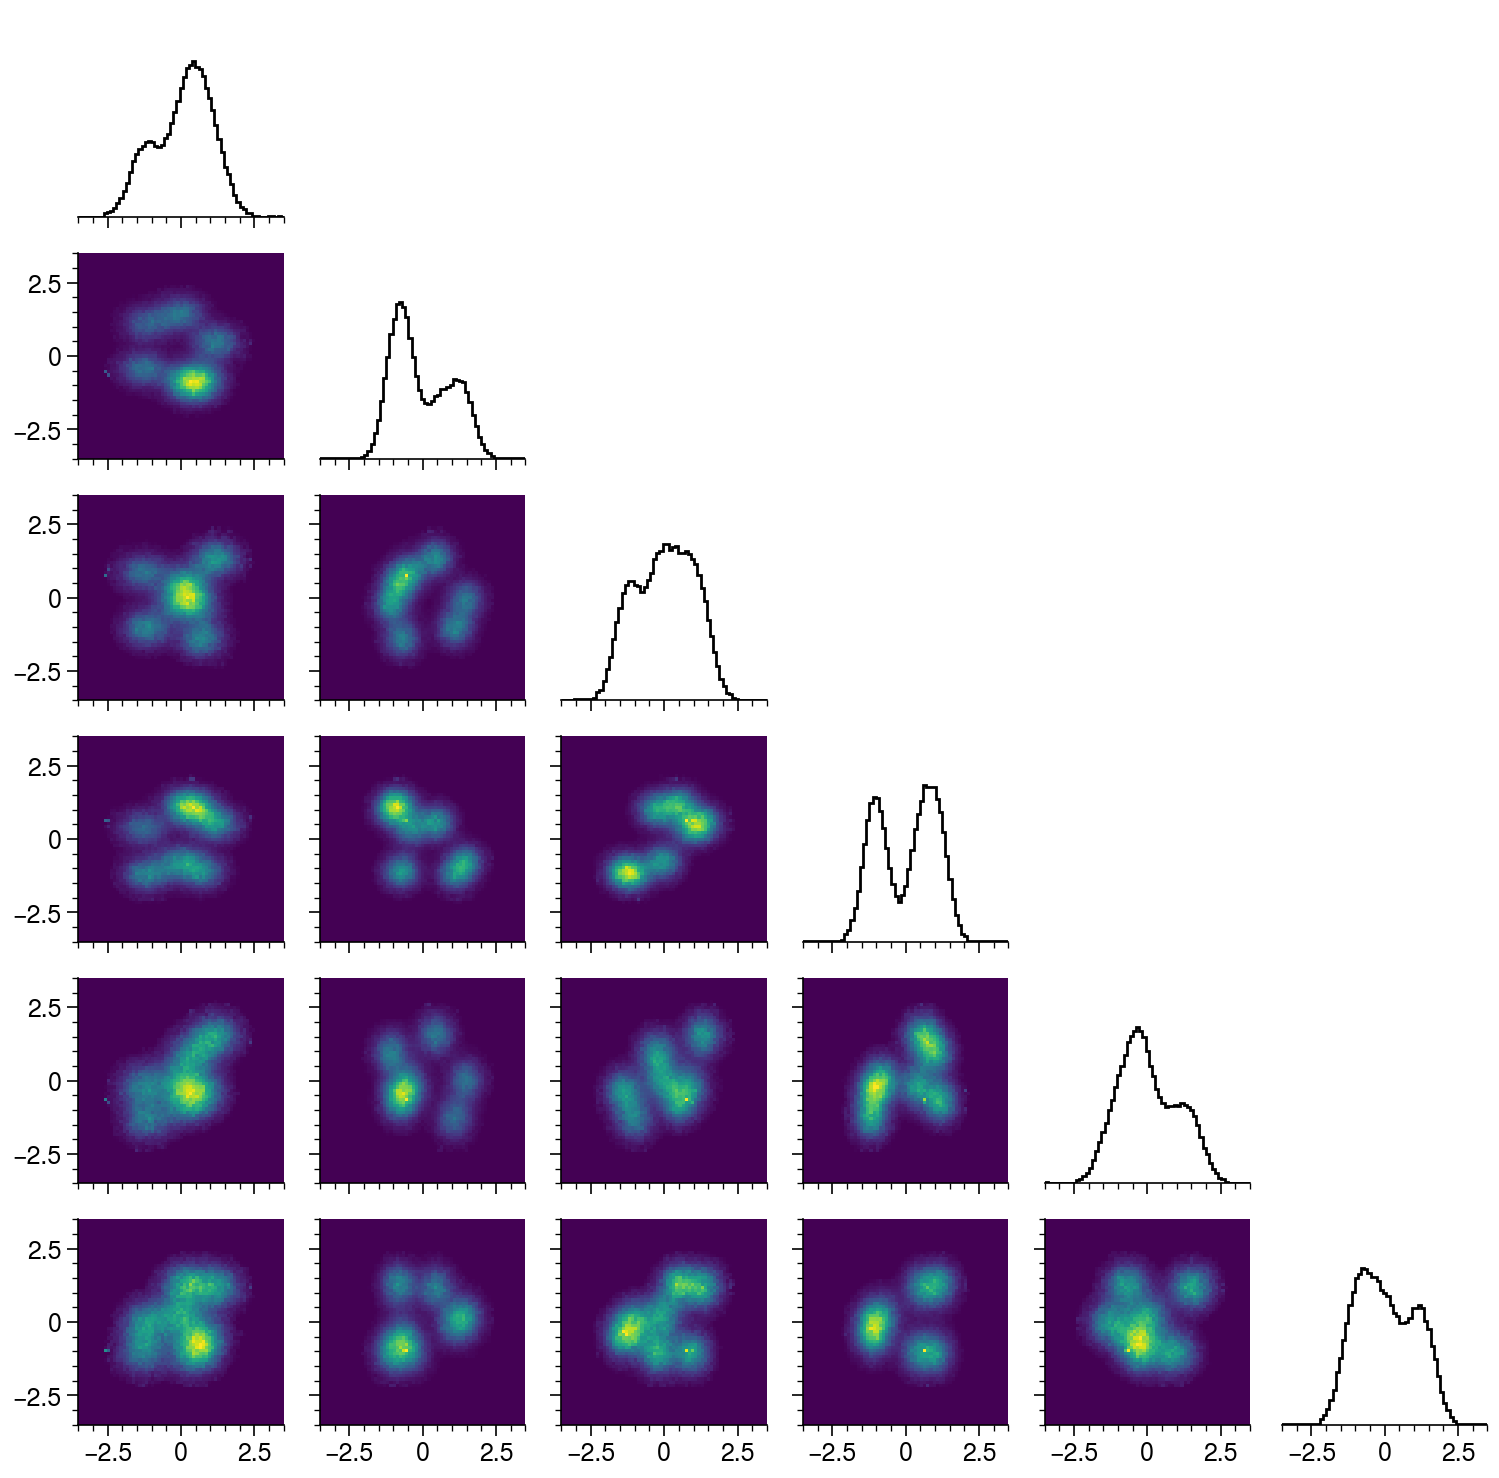

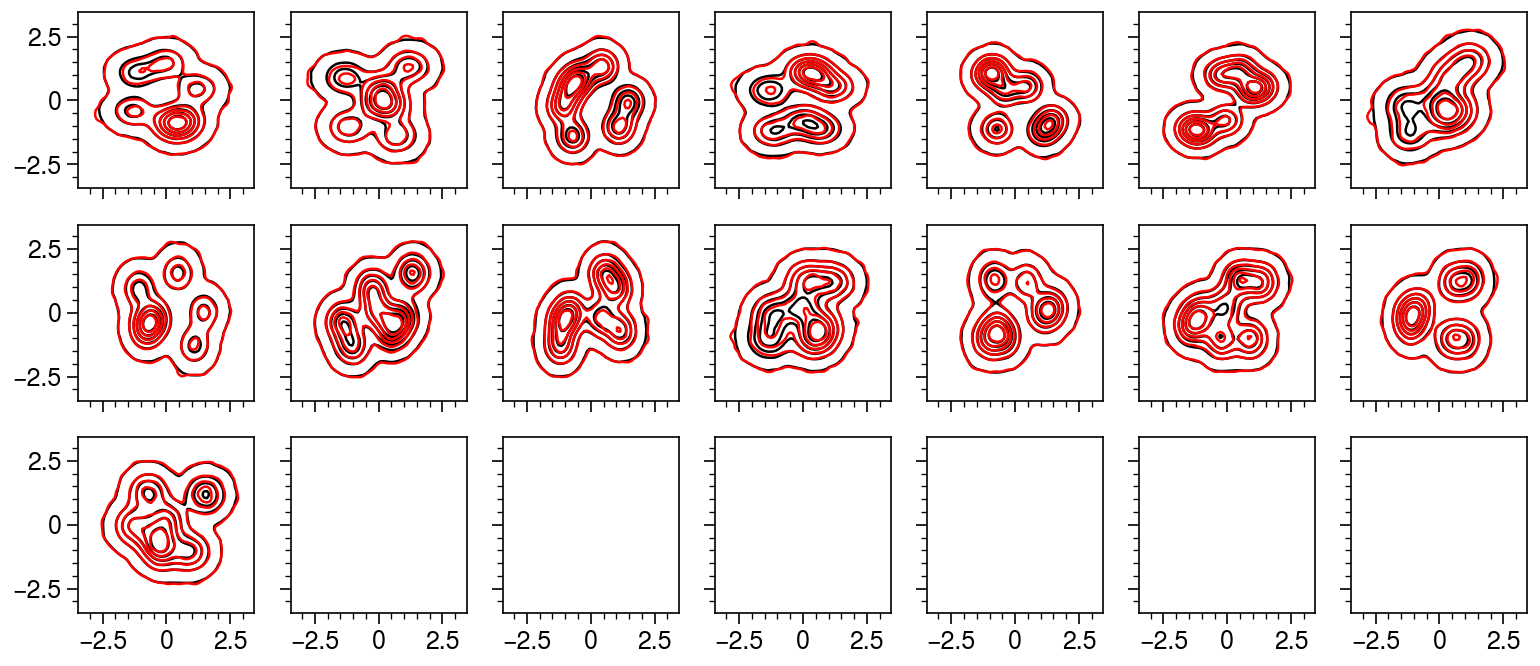

None


In [13]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)
trainer.train(
    epochs=3,
    learning_rate=0.80,
)

## Evaluate

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

  5%|█████▏                                                                                                           | 68/1499 [00:00<00:02, 672.33it/s]

  9%|██████████▍                                                                                                     | 140/1499 [00:00<00:01, 695.21it/s]

 14%|███████████████▊                                                                                                | 212/1499 [00:00<00:01, 704.45it/s]

 19%|█████████████████████▏                                                                                          | 284/1499 [00:00<00:01, 706.46it/s]

 24%|██████████████████████████▌                                                                                     | 356/1499 [00:00<00:01, 710.38it/s]

 29%|███████████████████████████████▉                                                                                | 428/1499 [00:00<00:01, 712.87it/s]

 33%|█████████████████████████████████████▎                                                                          | 500/1499 [00:00<00:01, 710.46it/s]

 38%|██████████████████████████████████████████▋                                                                     | 572/1499 [00:00<00:01, 708.20it/s]

 43%|████████████████████████████████████████████████                                                                | 643/1499 [00:00<00:01, 708.55it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 714/1499 [00:01<00:01, 708.76it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 786/1499 [00:01<00:01, 710.51it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 858/1499 [00:01<00:00, 712.69it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 930/1499 [00:01<00:00, 704.35it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1001/1499 [00:01<00:00, 704.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1073/1499 [00:01<00:00, 706.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1145/1499 [00:01<00:00, 709.57it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1217/1499 [00:01<00:00, 710.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1289/1499 [00:01<00:00, 712.66it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1361/1499 [00:01<00:00, 713.47it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1433/1499 [00:02<00:00, 714.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 709.45it/s]

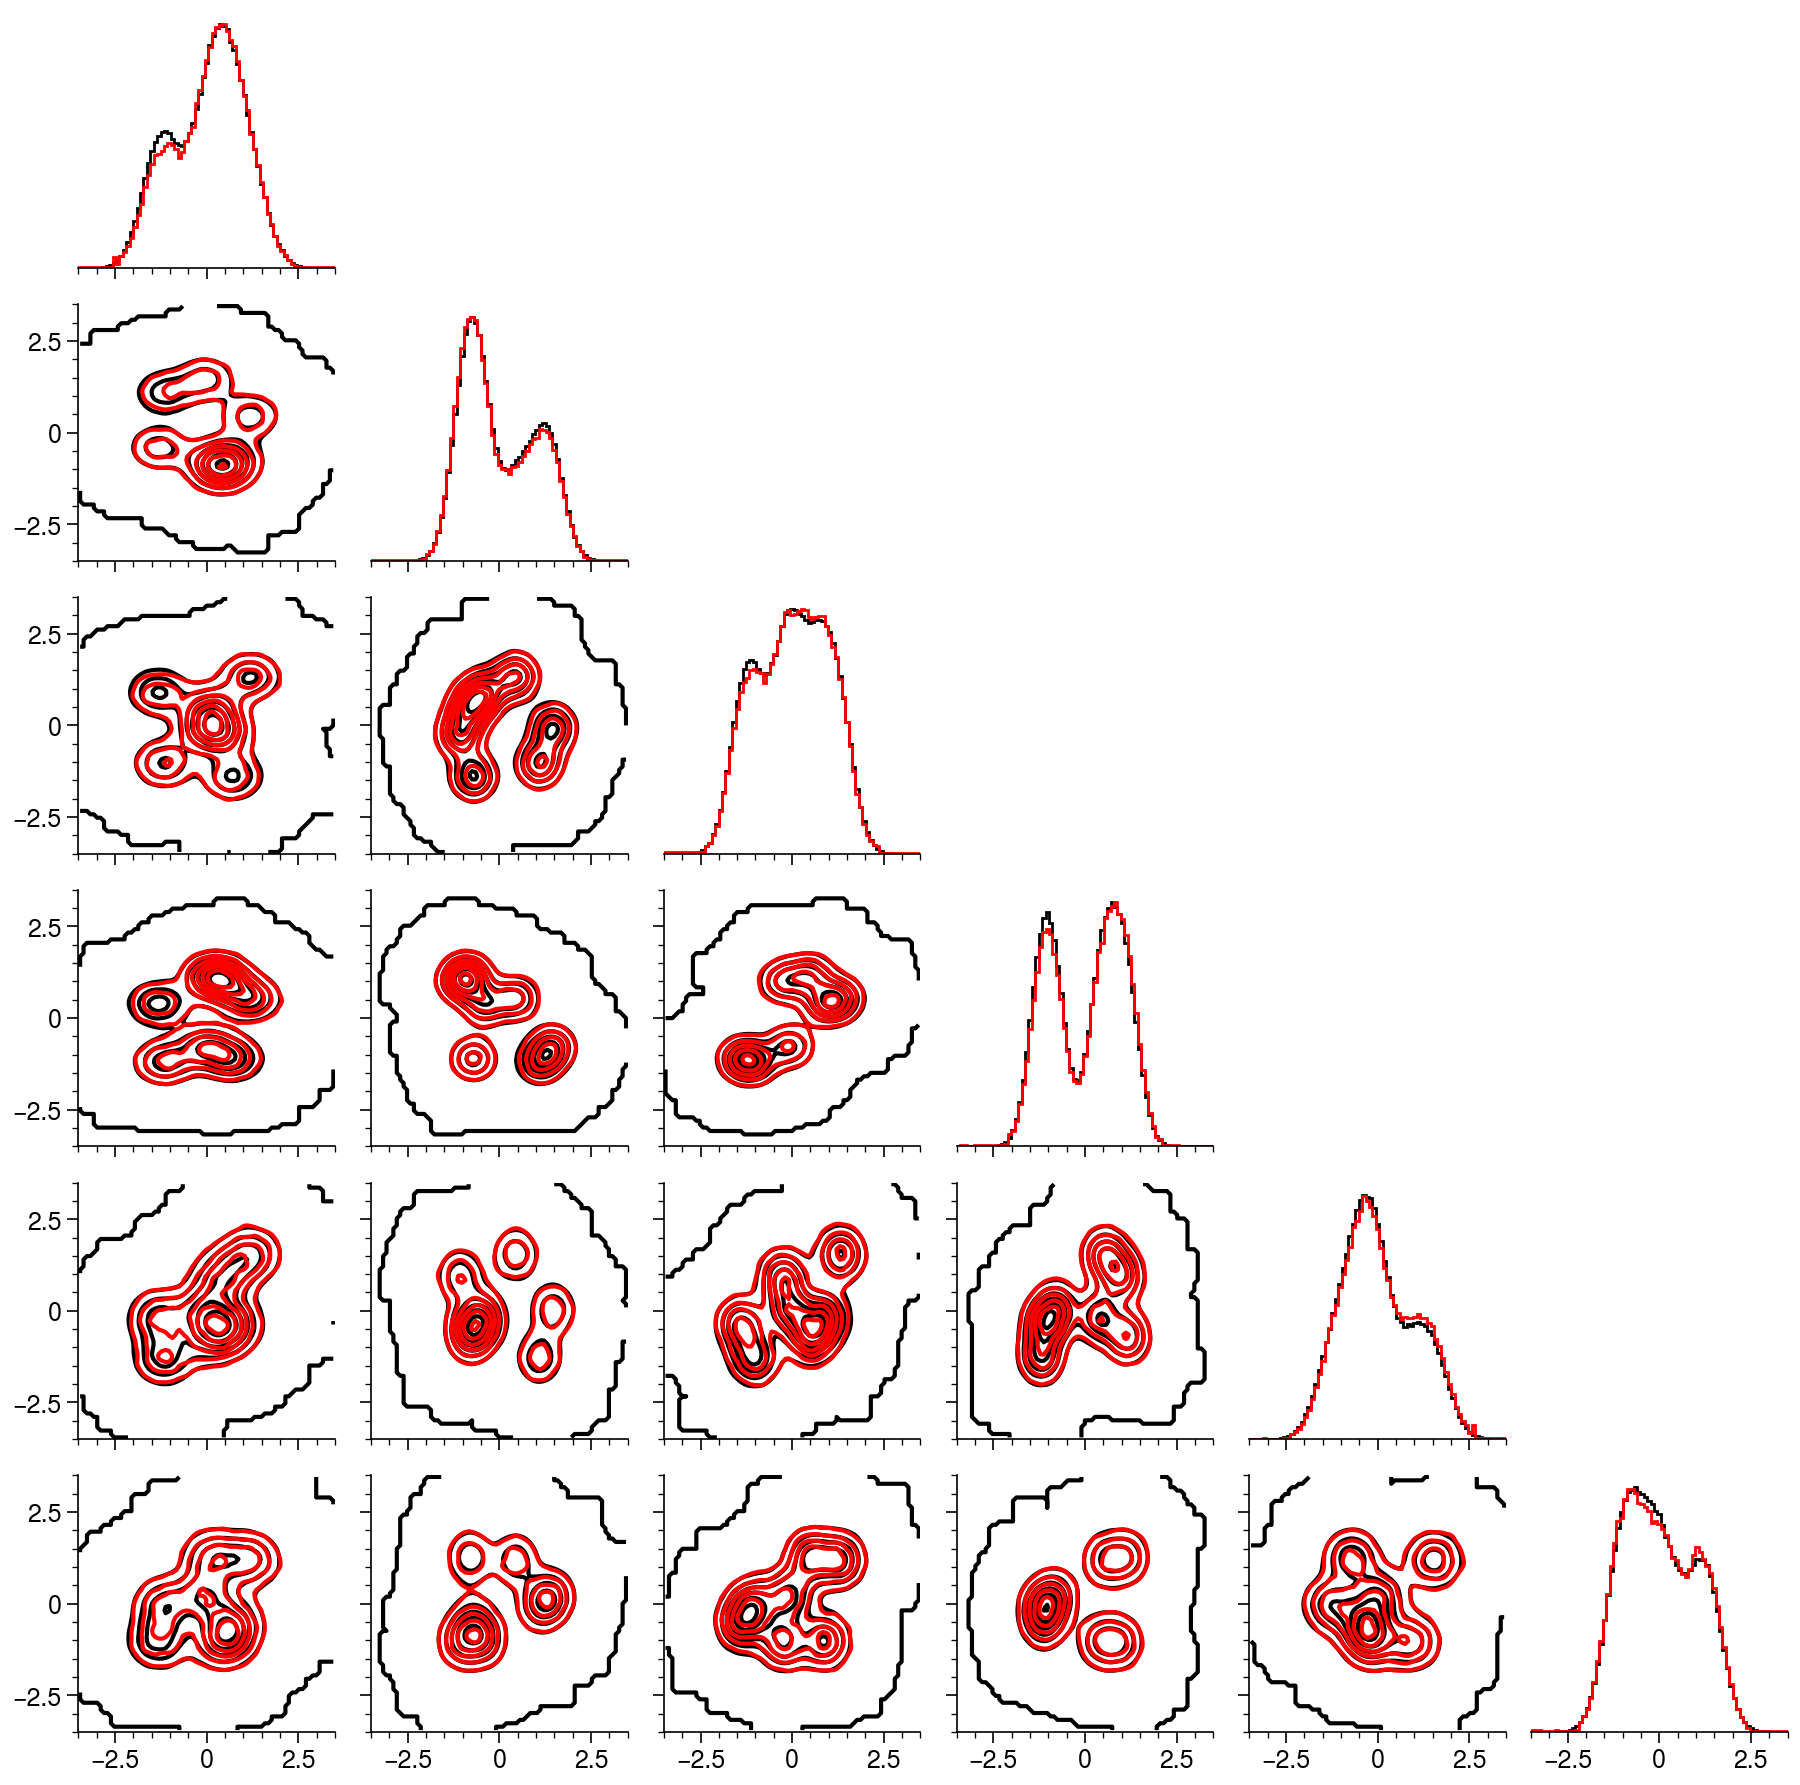

In [14]:
x_pred = model.unnormalize(model.sample(1_000_000))

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
for x, color in zip([x_true, x_pred], ["black", "red"]):
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color),
        mask=False,
        kind="contour",
        process_kws=dict(blur=1.0),
        color=color,
        N=7,
    )
plt.show()